# ***Analyzing Granted Projects of the European Research Council (ERC) to Understand Where Science Money Goes***

Final project in the course "The Art of Analyzing Big Data - The Data Scientist’s Toolbox Final Project".

Authors: Aviv Rovshitz & Leor Ariel Rose.

## ***Setup***



### ***Import packages***

Let's begin with importing all necessary packages:

In [1]:
!pip install pycountry
!pip install scholarly
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install transformers
!pip install shap

from typing import List
import json
import os
import re
import torch
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import pycountry
import warnings
import missingno as msno
import xgboost as xgb
import shap
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from tqdm import tqdm_notebook as tqdm
from plotly import express as px
from pathlib import Path
from pprint import pprint
from wordcloud import WordCloud
from itertools import combinations
from scholarly import scholarly
from sklearn.manifold import TSNE
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          AutoConfig, AutoModel)
from transformers import TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaModel
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

warnings.filterwarnings("ignore")
sns.set_context("paper")

  Using cached pycountry-22.3.5.tar.gz (10.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681831 sha256=65fa9e1c125bec7357bf72e665bb284862e0e37bdd33c35b167b1dc9ba420c51
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means exception groups will not show full tracebacks.


### ***Constant definitions***

Next, let's define all constant variables:

In [2]:
# Define path to data
DATA_PATH = Path("./data")
# Define path to erc data csv
ERC_DATA_FILE = "https://raw.githubusercontent.com/leorrose/ERC_analysis/main/data/erc_data.csv"
# Define path to erc dates csv
ERC_DATES_FILE = "https://raw.githubusercontent.com/leorrose/ERC_analysis/main/data/erc_dates.csv"

### ***Auxiliary methods***

Next, let's define all auxiliary methods:


In [3]:
def symbol_to_name(symbol) -> str:
    """Function to convert country symbol to name

    Args:
        symbol (str): country symbol

    Returns:
        str: country name
    """
    try:
        country = pycountry.countries.get(alpha_2=symbol)
        return country.name
    except AttributeError:
        return "Unknown"

## ***Data loading***

For this project we are going to use the [ERC dataset](https://erc.easme-web.eu/#). This dataset has information about projects funded by the European Research Council. The data has all the needed information except dates of each project which we scraped from their new [dashboard](https://dashboard.tech.ec.europa.eu/qs_digit_dashboard_mt/public/sense/app/afe00964-3272-45c4-b60c-b64ed20d98d1/sheet/61a0bd1d-cd6d-4ac8-8b55-80d8661e44c0/state/analysis) using selenium (code: [date_scraper.ipynb](https://github.com/leorrose/ERC_analysis/blob/main/date_scraper.ipynb)).

Let's read the data:

In [4]:
# Read erc csv
erc_data_df = pd.read_csv(ERC_DATA_FILE, delimiter=';')
erc_data_df["Project number"] = erc_data_df["Project number"].astype("Int32")
erc_data_df["Project budget"] = erc_data_df["Project budget"].str.replace(
    ".", ''
).astype("float32")

# Read erc projects dates
erc_dates_df = pd.read_csv(ERC_DATES_FILE)
erc_dates_df["Project number"] = erc_dates_df["Project number"].astype("Int32")
erc_dates_df["Start Date"] = pd.to_datetime(erc_dates_df["Start Date"])
erc_dates_df["End Date"] = pd.to_datetime(erc_dates_df["End Date"])

# Combine data frames
erc_full_df = pd.merge(
    erc_data_df, erc_dates_df, on="Project number", how="left"
)

## ***Data cleaning***

In this section we will clean the data and validate it is usable for statistical analysis and machine learning pipelines.

### ***Missing data***

Let's begin by looking at the percentage of missing values in each column:

In [5]:
# Print the percentage of missing values in each column
print("Percentage of missing values in each colum")
erc_full_df.isna().sum() / erc_full_df.shape[0]

Percentage of missing values in each colum


Project number      0.006908
Project acronym     0.000000
Project title       0.000000
Abstract            0.027079
PI                  0.007461
Grant type          0.006977
Topic               0.024109
Project budget      0.006908
Call ID             0.006908
Host Institution    0.006908
City                0.013816
Country             0.013816
Start Date          0.006908
End Date            0.006908
dtype: float64

We can see that there are not a lot of missing values (~0.03%), but lets take a deeper look using missingno:

Nullity matrix of the data:



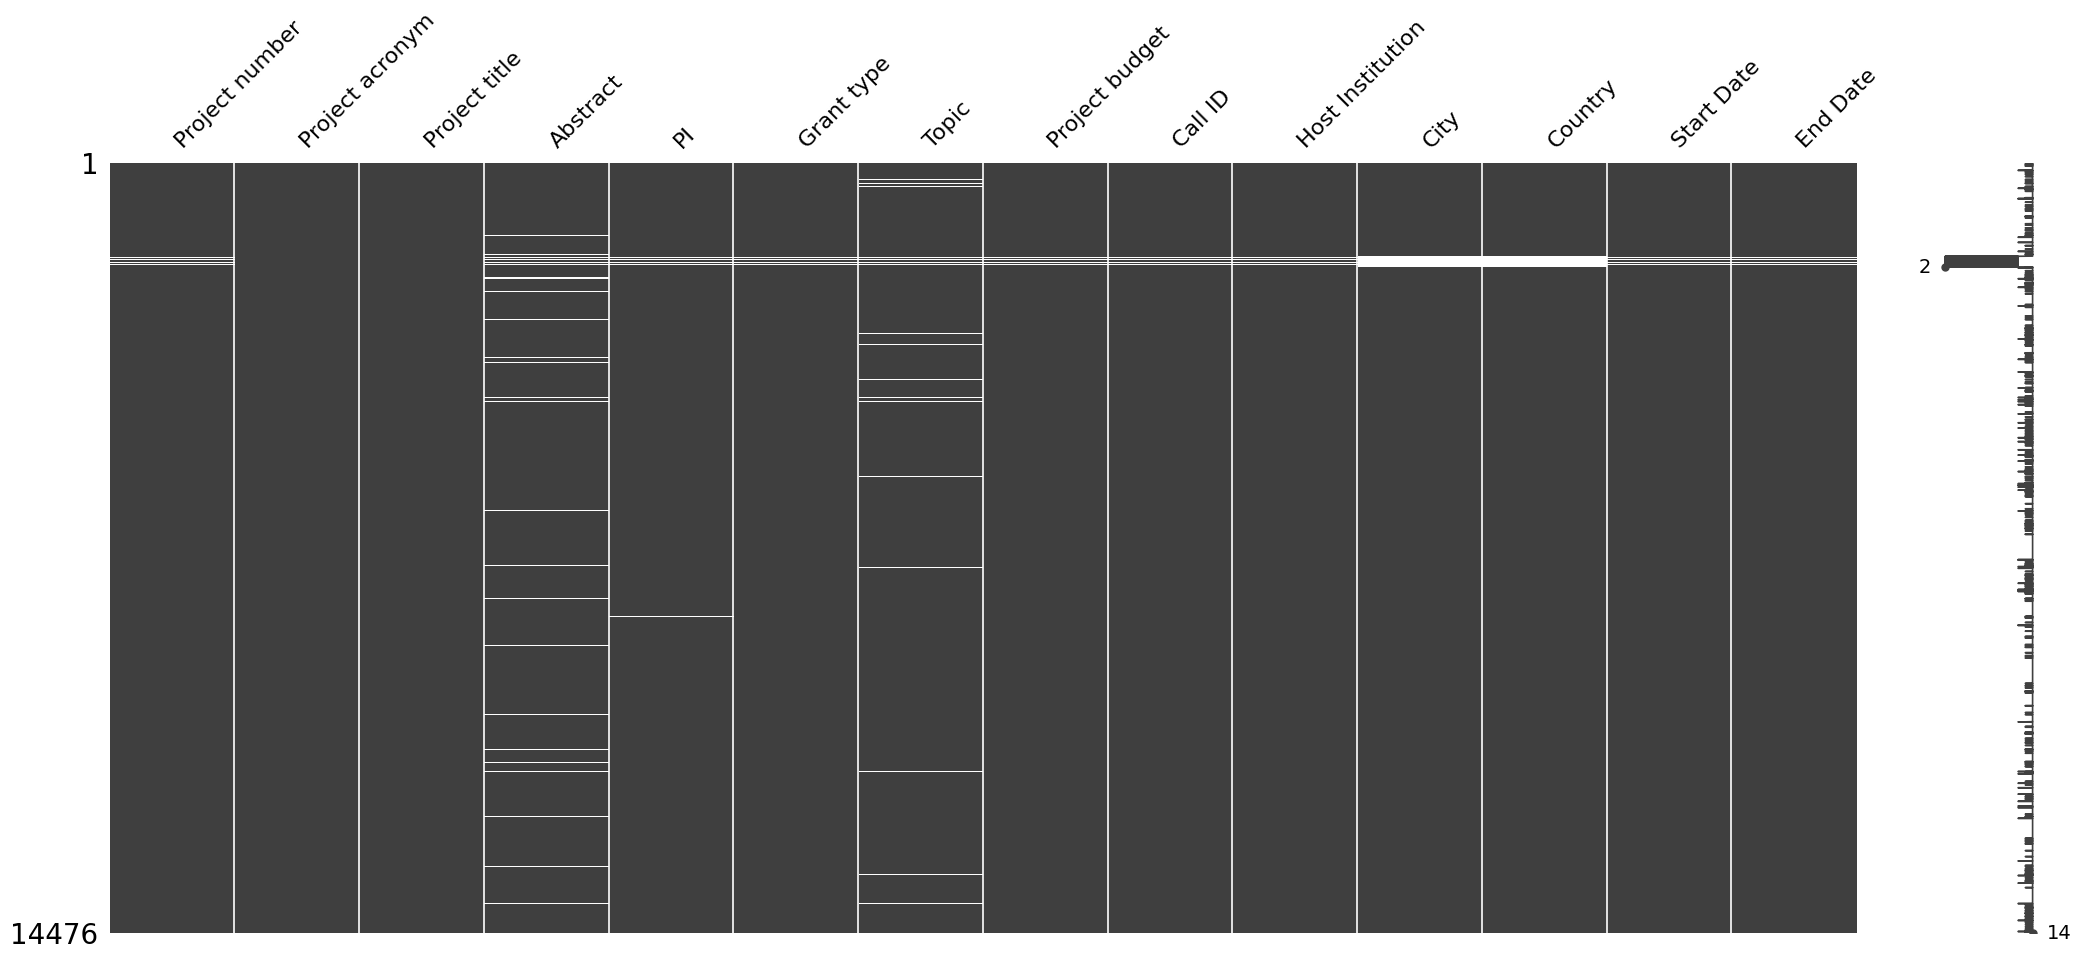

In [6]:
# Visualize the nullity matrix
print("Nullity matrix of the data:", end="\n\n")
ax = msno.matrix(erc_full_df)

Looking at the nullity matrix we can see that records where project number does not exist have a lot of other missing values, so let's get rid of them:

In [7]:
# Print the percentage of missing values in each column
print(
    "Percentage of missing values in each colum (after removing)"
    " 'Project number' empty records"
)
erc_full_df.isna().sum() / erc_full_df.shape[0]

Percentage of missing values in each colum (after removing) 'Project number' empty records


Project number      0.006908
Project acronym     0.000000
Project title       0.000000
Abstract            0.027079
PI                  0.007461
Grant type          0.006977
Topic               0.024109
Project budget      0.006908
Call ID             0.006908
Host Institution    0.006908
City                0.013816
Country             0.013816
Start Date          0.006908
End Date            0.006908
dtype: float64

Nullity matrix of the data (after removing 'Project number' empty records):



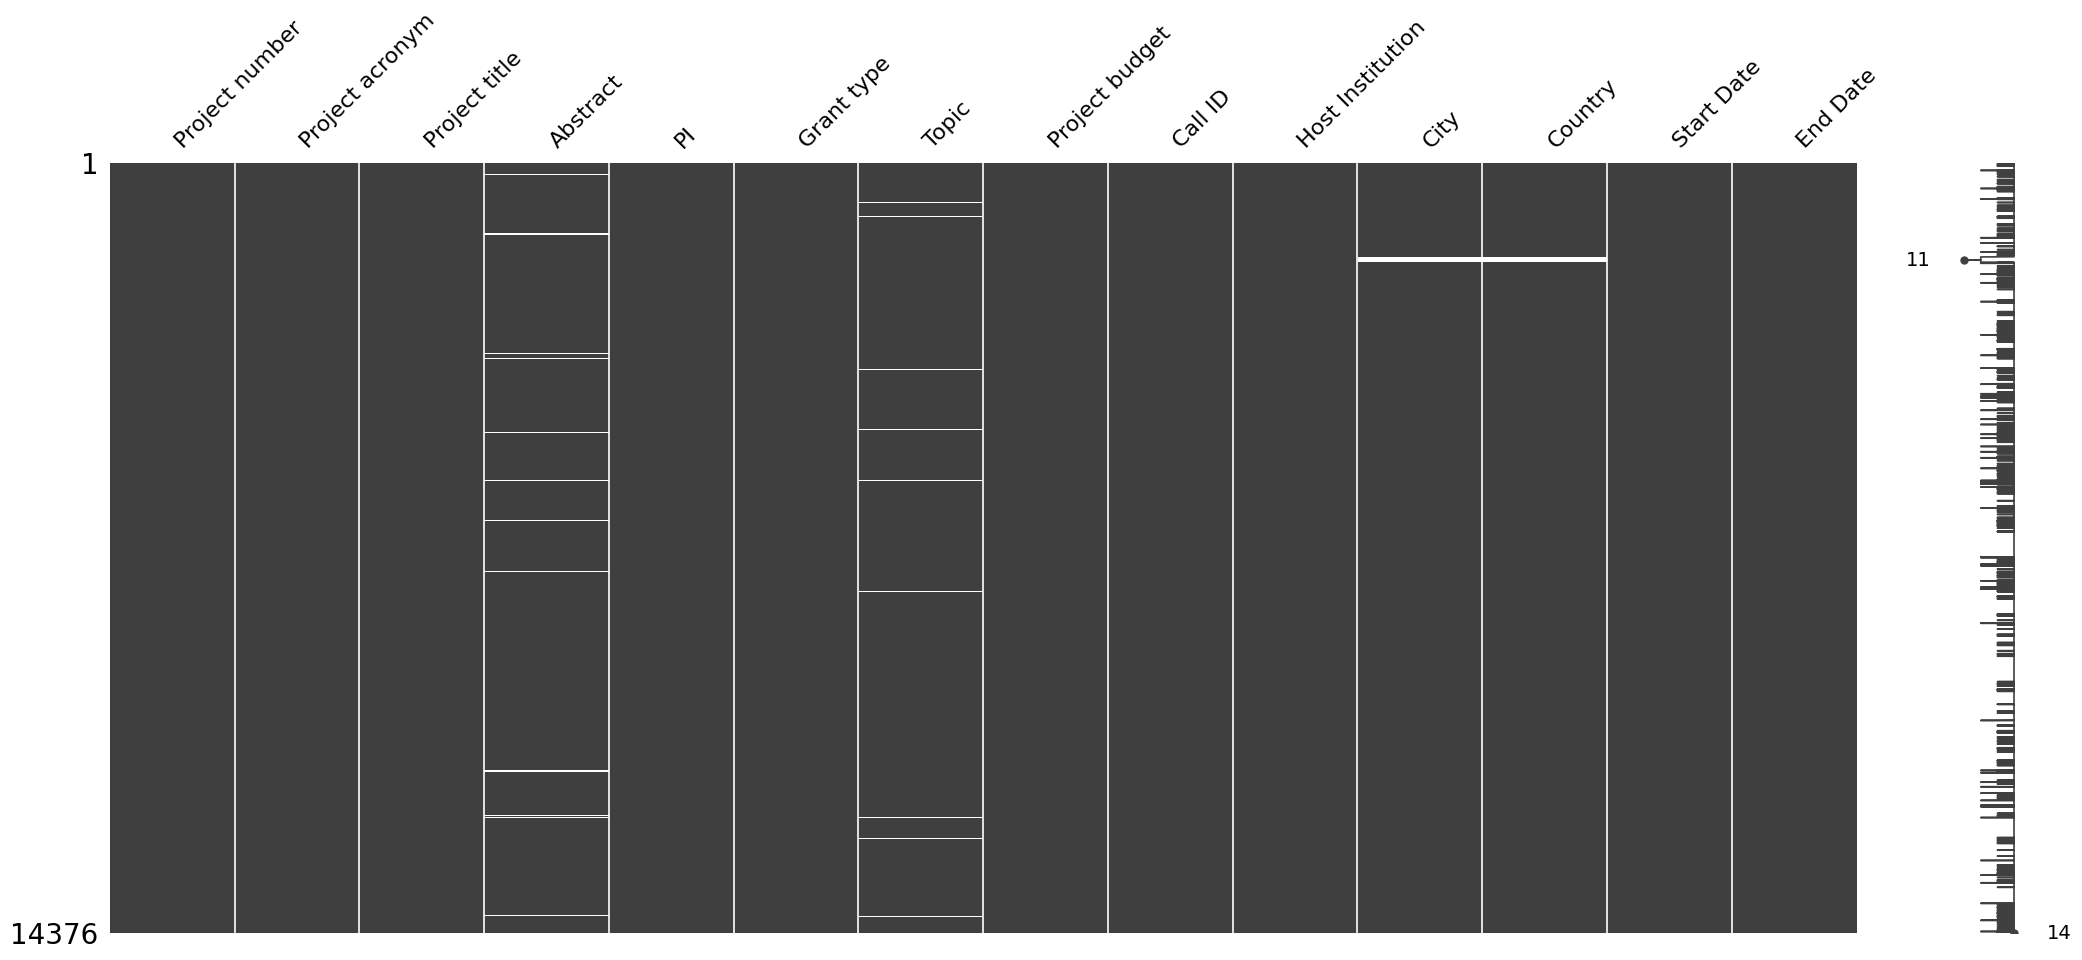

In [8]:
# Get tid of records without project number
erc_full_df = erc_full_df[~erc_full_df["Project number"].isna()]
print(
    (
        "Nullity matrix of the data (after removing"
        " 'Project number' empty records):"
    ), end="\n\n"
)
ax = msno.matrix(erc_full_df)

Now it looks like we have missing abstracts, PI, grant types, topics, cities and countries.
Let's look at the missing cities and countries to see if we can impute it:

In [9]:
# Print the Host Institution of records with missing country
erc_full_df[(erc_full_df["Country"].isna())]["Host Institution"].unique()

array(['French Alternative Energies and Atomic Energy Commission'],
      dtype=object)

In [10]:
# Print the Host Institution of records with missing city
erc_full_df[(erc_full_df["City"].isna())]["Host Institution"].unique()

array(['French Alternative Energies and Atomic Energy Commission'],
      dtype=object)

So the Host Institution of all the missing cities and countries is "French Alternative Energies and Atomic Energy Commission" so we can impute the country France and the city Paris:

In [11]:
# Fill 'FR' & 'Paris' in Country & City
indexes = erc_full_df[(erc_full_df["Country"].isna()) | (erc_full_df["City"].isna())].index.tolist()
erc_full_df.loc[indexes, "City"]= "Paris"
erc_full_df.loc[indexes, "Country"] = "FR"

Next, let's look at the missing grant type:

In [12]:
erc_full_df[erc_full_df["Grant type"].isna()]

Project number Project acronym  \
11659       101071255          X-MESH   

                                           Project title Abstract  \
11659  An eXtreme Mesh deformation method to follow s...      NaN   

                          PI Grant type           Topic  Project budget  \
11659  REMACLE Jean-François        NaN  Synergy Grants             0.0   

            Call ID       Host Institution              City Country  \
11659  ERC-2022-SYG  University of Louvain  LOUVAIN-LA-NEUVE      BE   

      Start Date   End Date  
11659 2023-01-09 2029-08-31

We an see the missing Grant type has 0.0 budget so lets remove this record because it does not have any valuable information:

In [13]:
erc_full_df=erc_full_df[~erc_full_df["Grant type"].isna()]

We can not impute the abstract, PI or topic but we still have valuable information in these records so we will not remove them.

### ***Adding new columns***

Let's create a column containing the country name and not only country symbol:

In [14]:
# Fix symbol of United Kingdom and Greece
erc_full_df.loc[erc_full_df.Country == "UK", "Country"] = "GB"
erc_full_df.loc[erc_full_df.Country == "EL", "Country"] = "GR"
# Get country name for each record
erc_full_df["Country name"] = erc_full_df.Country.apply(symbol_to_name)

Next, let's add some new columns regarding each projects date:

In [15]:
# Add project years & days duration
erc_full_df["days_duration"] = (erc_full_df["End Date"] - erc_full_df["Start Date"]).dt.days
erc_full_df["years_duration"] = erc_full_df["days_duration"]  / 365
erc_full_df["start_year"] = erc_full_df["Start Date"].dt.year

## **Univariate descriptive statistics**

Let's begin with visualizing the number of grants by grant type:

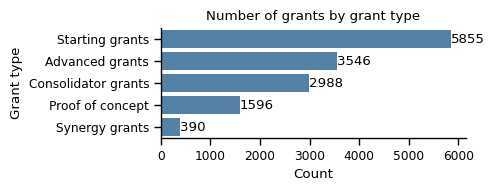

In [16]:
# Plot the number of grants by grant type
column = "Grant type"
fig, ax = plt.subplots(figsize=(5, 2))
ax = sns.countplot(
    erc_full_df, y=column, order=erc_full_df[column].value_counts().index,
    ax=ax, color="steelblue"
)
ax.bar_label(ax.containers[0])
plt.title(f"Number of grants by {column.lower()}")
plt.xlabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the number of grants by topic:

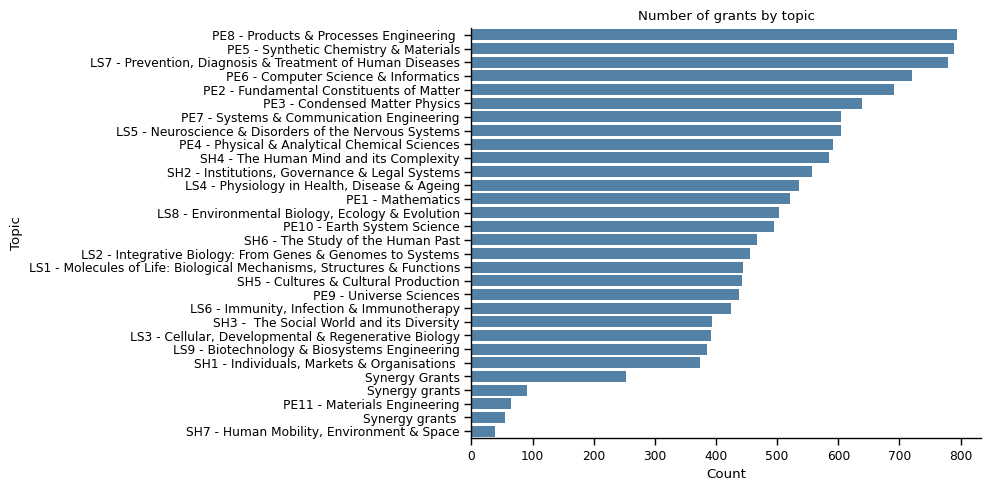

In [17]:
# Plot the number of grants by topic
column = "Topic"
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(
    erc_full_df, y=column, order=erc_full_df[column].value_counts().index,
    ax=ax, color="steelblue"
)
plt.title(f"Number of grants by {column.lower()}")
plt.xlabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the number of grants by host institution:

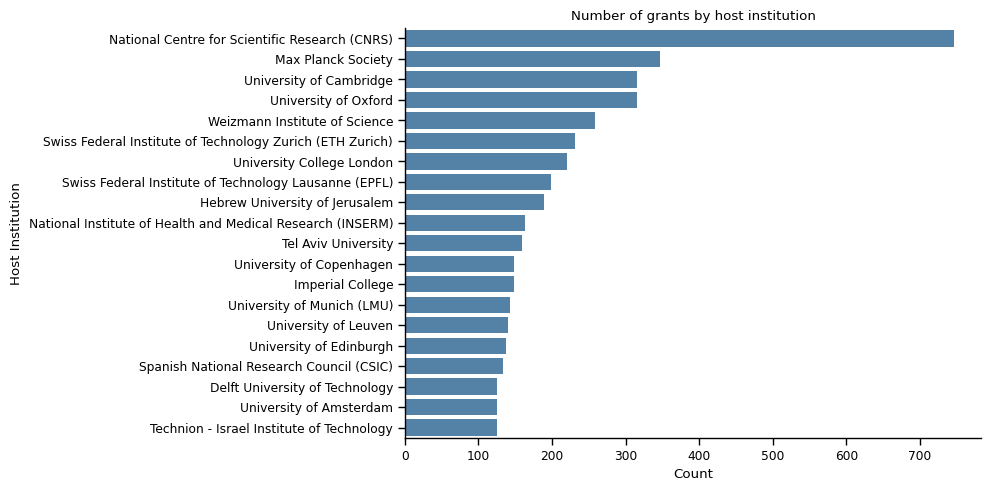

In [18]:
# Plot the number of grants by host institution
top_k = 20
column = "Host Institution"
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(
    erc_full_df, y=column,
    order=erc_full_df[column].value_counts().iloc[:top_k].index, ax=ax,
    color="steelblue"
)
plt.title(f"Number of grants by {column.lower()}")
plt.xlabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the number of grants by call ID:

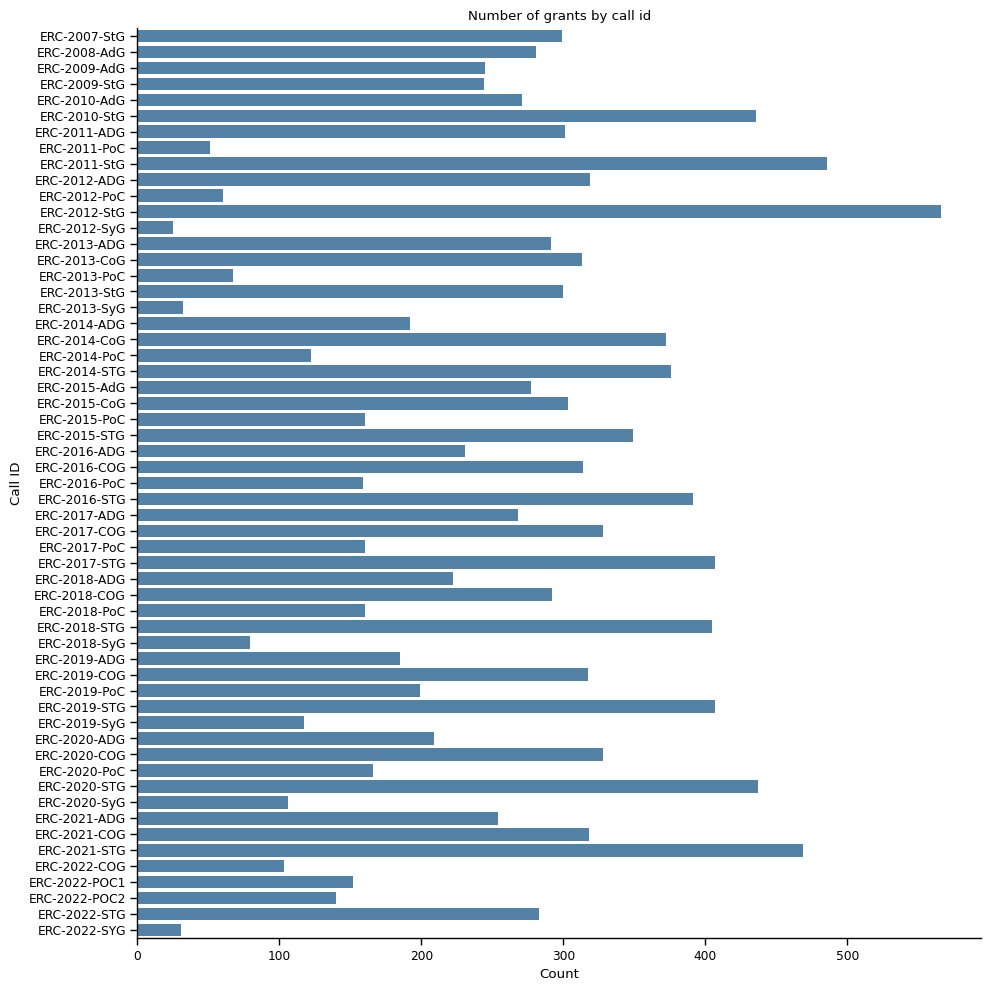

In [19]:
# Plot the number of grants by Call ID
column = "Call ID"
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(
    erc_full_df, y=column, order=np.sort(
        erc_full_df.loc[~erc_full_df[column].isna(), column].unique()
    ), ax=ax, color="steelblue"
)
plt.title(f"Number of grants by {column.lower()}")
plt.xlabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the number of grants by country name:

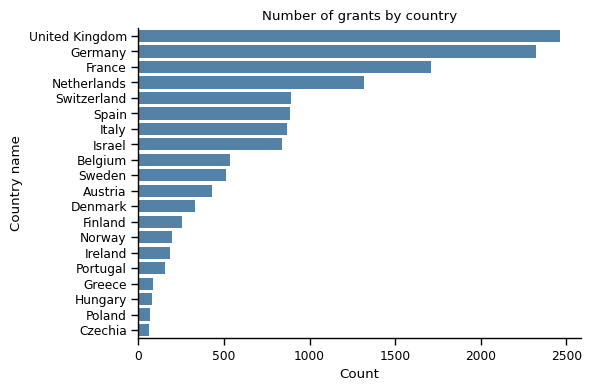

In [20]:
# Plot the number of project distribution by country
top_k = 20
column = "Country name"
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(
    erc_full_df, y=column,
    order=erc_full_df[column].value_counts().iloc[:top_k].index, ax=ax,
    color="steelblue"
)
plt.title(f"Number of grants by country")
plt.xlabel("Count")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the grants budget distribution:

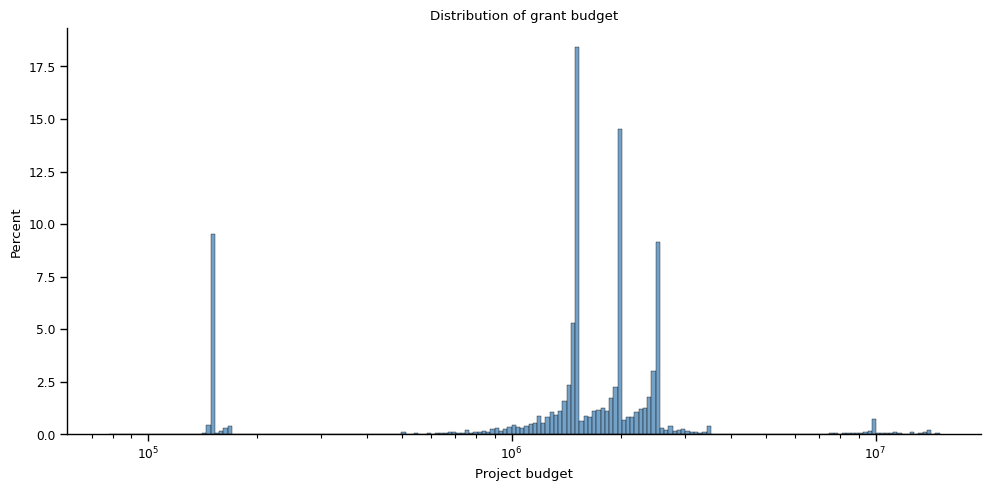

In [21]:
# Plot the grants budget distribution
column = "Project budget"
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    erc_full_df, x=column, ax=ax, color="steelblue", log_scale=True,
    stat="percent"
)
plt.title(f"Distribution of grant budget")
sns.despine()
plt.tight_layout()
plt.show()

Next, let's visualize the grant year duration distribution:

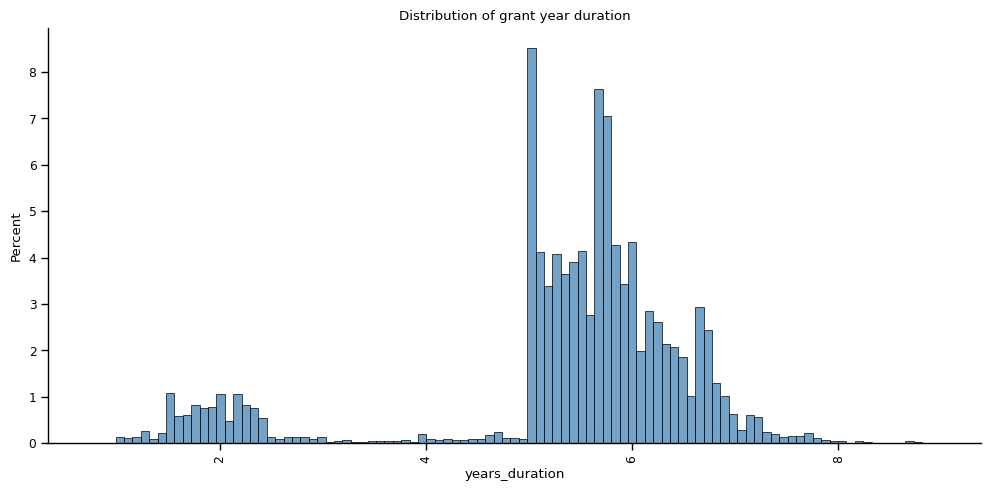

In [22]:
# Plot the grant year duration distribution
column = "years_duration"
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(
    erc_full_df, x=column, ax=ax, color="steelblue",
    stat="percent"
)
plt.title(f"Distribution of grant year duration")
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.show()

Let's visualize the most common words in grants titles:

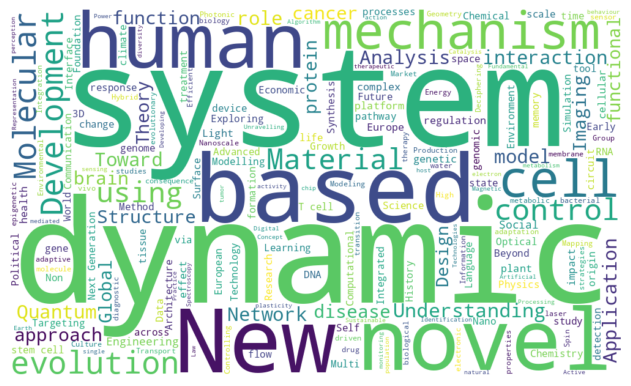

In [23]:
wordcloud = WordCloud(width=1000, height=600, background_color="white")
wordcloud.generate(" ".join(erc_full_df["Project title"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

Let's visualize the most common words in grants abstract:

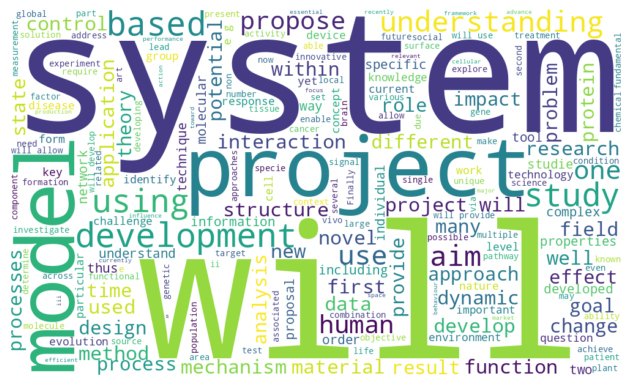

In [24]:
wordcloud = WordCloud(width=1000, height=600, background_color="white")
wordcloud.generate(" ".join(erc_full_df.loc[~erc_full_df["Abstract"].isna(), "Abstract"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

## **Multivariate  descriptive statistics**

Let's visualize the number of grants each year by grant type:

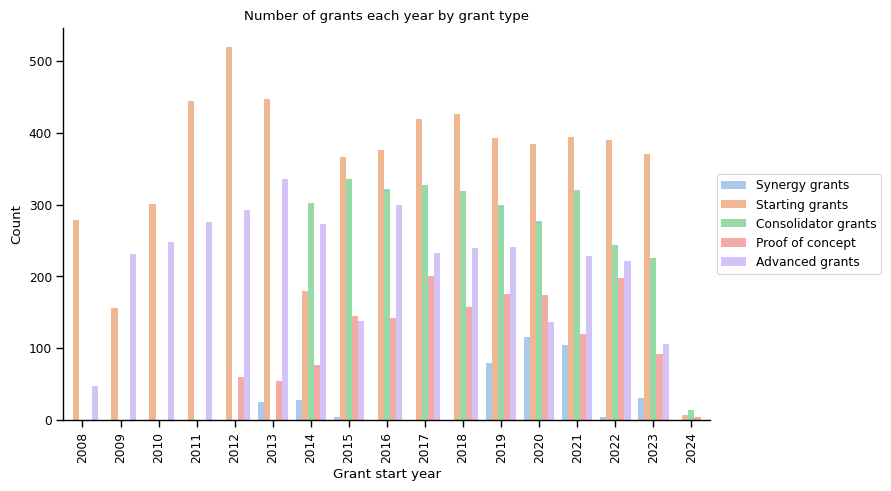

In [25]:
# Plot number of grants each year by grant type"
column = "start_year"
fig, ax = plt.subplots(figsize=(9, 5))
ax = sns.countplot(
    erc_full_df, x=column, hue="Grant type" ,order=np.sort(
        erc_full_df.loc[~erc_full_df[column].isna(), column].unique()
    ), ax=ax, palette="pastel"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(f"Number of grants each year by grant type")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.xlabel("Grant start year")
sns.despine()
plt.tight_layout()
plt.show()

Let's visualize the grants budget each year by grant type:

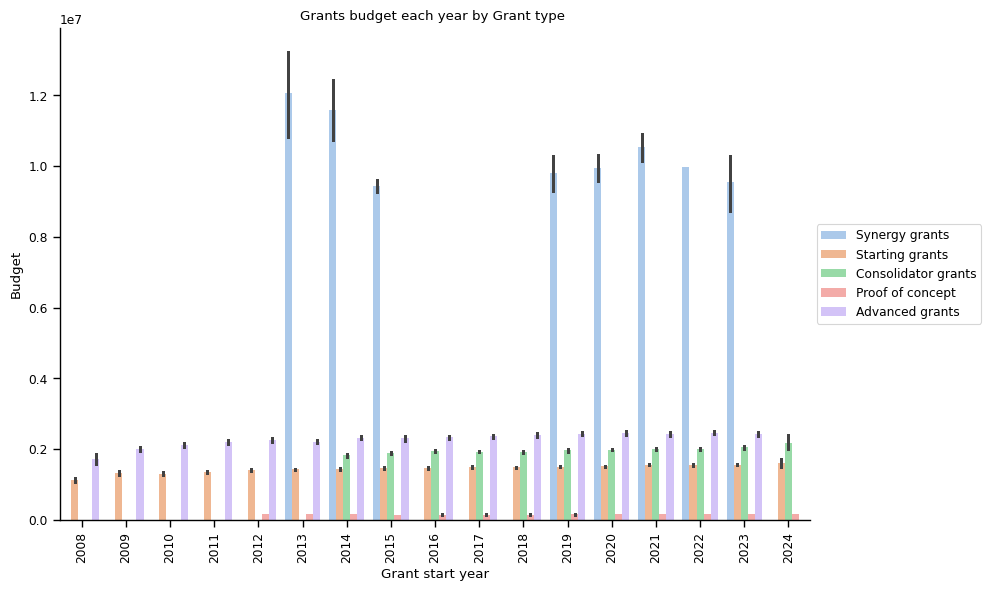

In [26]:
# Plot grants budget each year by grant type:
column = "start_year"
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(
    erc_full_df, x=column, y="Project budget", hue="Grant type" ,order=np.sort(
        erc_full_df.loc[~erc_full_df[column].isna(), column].unique()
    ), ax=ax, palette="pastel"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(f"Grants budget each year by Grant type ")
plt.xticks(rotation=90)
plt.ylabel("Budget")
plt.xlabel("Grant start year")
sns.despine()
plt.tight_layout()
plt.show()

Let's visualize the number of projects per host institution:

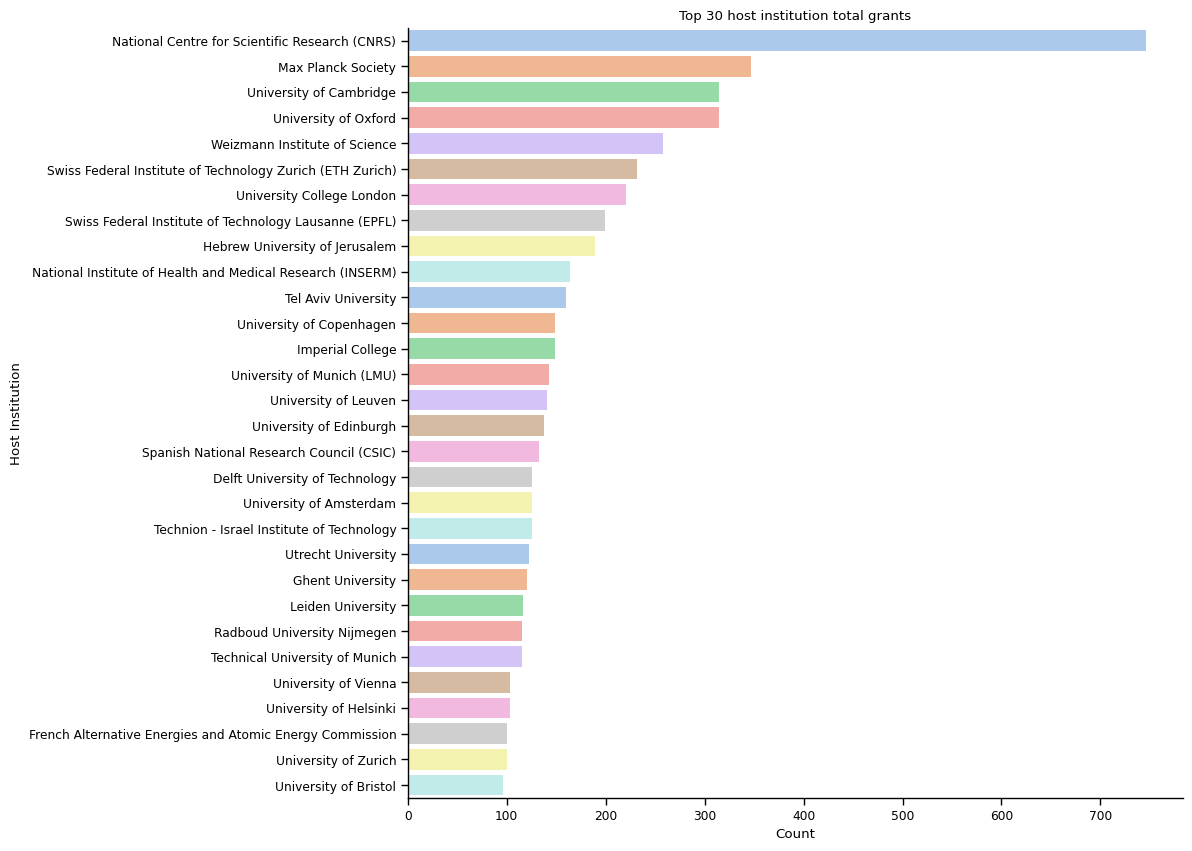

In [27]:
# Plot number of projects per host institution
column = "Host Institution"
top_k = 30
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(
    erc_full_df, y=column,
    order=erc_full_df.groupby(["Host Institution"]
                             ).size().sort_values(ascending=False
                                                 ).iloc[:top_k].index,
    palette="pastel"
)
plt.xlabel("Count")
sns.despine()
plt.title(f"Top {top_k} {column.lower()} total grants")
plt.show()

Let's visualize the grants budget by grant host institution:

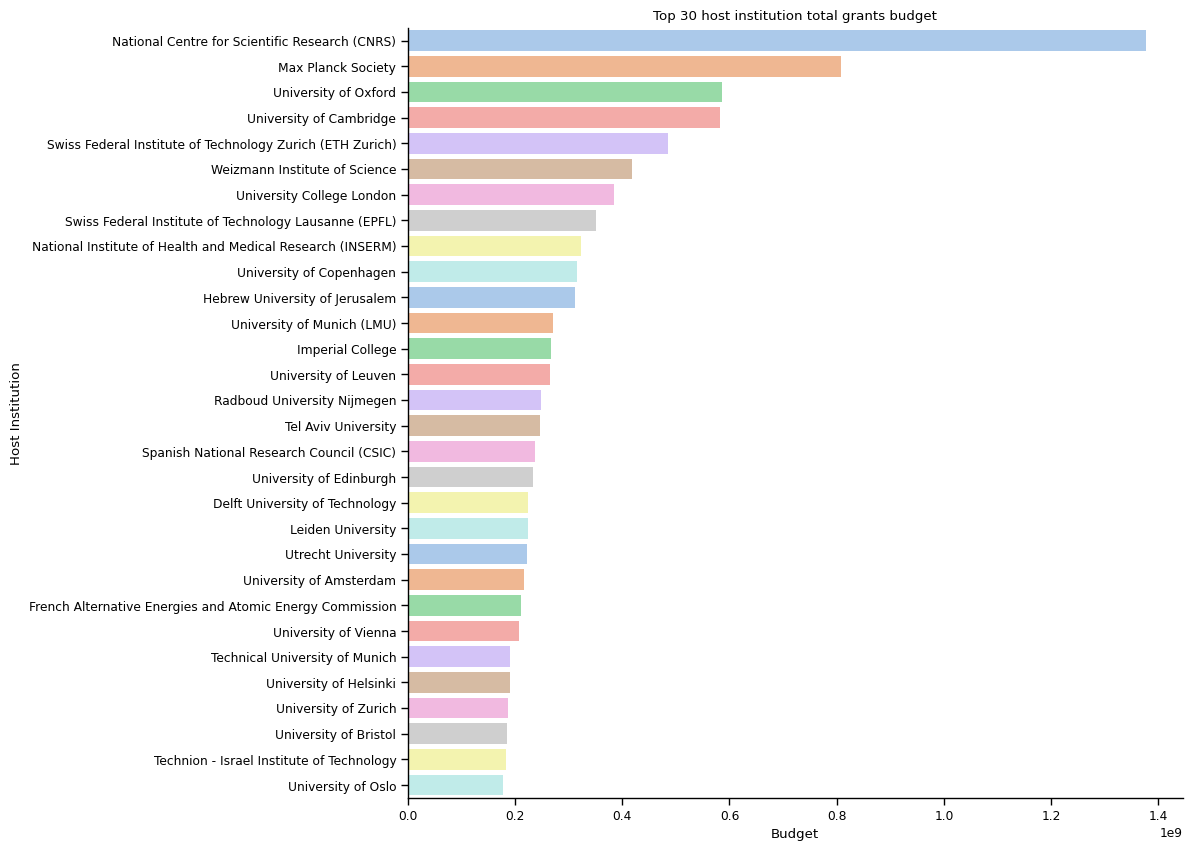

In [28]:
# Plot grants budget by grant host institution
column = "Host Institution"
top_k = 30
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    erc_full_df, y=column, x="Project budget", order=erc_full_df.groupby(
        [column]
    )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
    palette="pastel", errorbar=None, estimator=sum
)
plt.xlabel("Budget")
sns.despine()
plt.title(f"Top {top_k} {column.lower()} total grants budget")
plt.show()

Let's visualize the grants budget by grant host institution each year:

In [29]:
# Plot grants budget by grant host institution each year
for year in np.sort(erc_full_df["start_year"].unique()):
  loop_erc_full_df = erc_full_df[erc_full_df["start_year"] == year]
  column = "Host Institution"
  top_k = 30
  fig, ax = plt.subplots(figsize=(10, 10))
  ax = sns.barplot(
      loop_erc_full_df, y=column, x="Project budget",
      order=loop_erc_full_df.groupby(
          [column]
      )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
      palette="pastel", errorbar=None, estimator=sum
  )
  plt.xlabel("Budget")
  sns.despine()
  plt.title(f"Top {top_k} {column.lower()} total grants budget in year {year}")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's visualize the rants budget by grant topic:

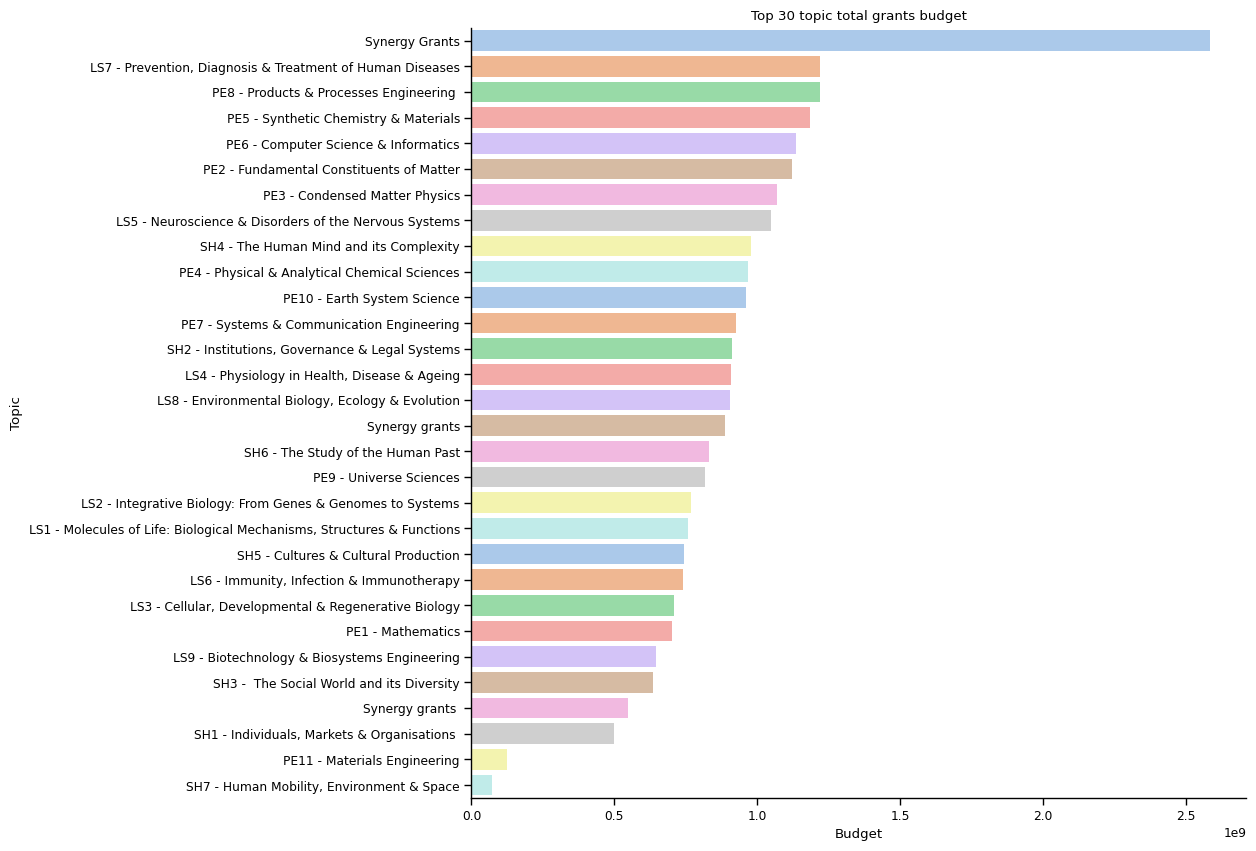

In [30]:
# Plot grants budget by grant topic
column = "Topic"
top_k = 30
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    erc_full_df,
    y=column, x="Project budget", order=erc_full_df.groupby(
        [column]
    )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
    palette="pastel", errorbar=None, estimator=sum
)
plt.xlabel("Budget")
sns.despine()
plt.title(f"Top {top_k} {column.lower()} total grants budget")
plt.show()

Let's visualize the grants budget by grant topic each year:

In [31]:
# Plot grants budget by grant topic each year
for year in np.sort(erc_full_df["start_year"].unique()):
  loop_erc_full_df = erc_full_df[erc_full_df["start_year"] == year]
  column = "Topic"
  top_k = 30
  fig, ax = plt.subplots(figsize=(10, 10))
  ax = sns.barplot(
      loop_erc_full_df, y=column, x="Project budget",
      order=loop_erc_full_df.groupby(
          [column]
      )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
      palette="pastel", errorbar=None, estimator=sum
  )
  plt.xlabel("Budget")
  sns.despine()
  plt.title(f"Top {top_k} {column.lower()} total grants budget in year {year}")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's visualize the grants budget by grant country:

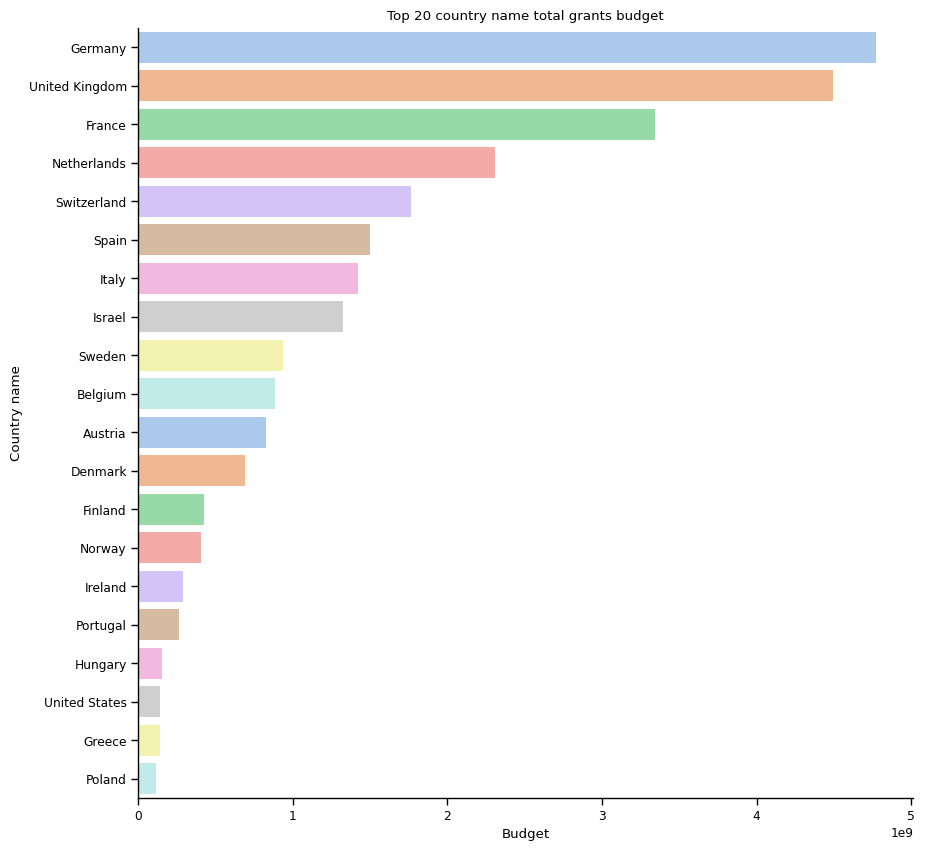

In [32]:
# Plot grants budget by grant country
column = "Country name"
top_k = 20
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(
    erc_full_df,
    y=column, x="Project budget", order=erc_full_df.groupby(
        [column]
    )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
    palette="pastel", errorbar=None, estimator=sum
)
plt.xlabel("Budget")
sns.despine()
plt.title(f"Top {top_k} {column.lower()} total grants budget")
plt.show()

Let's visualize the grants budget by grant country each year:

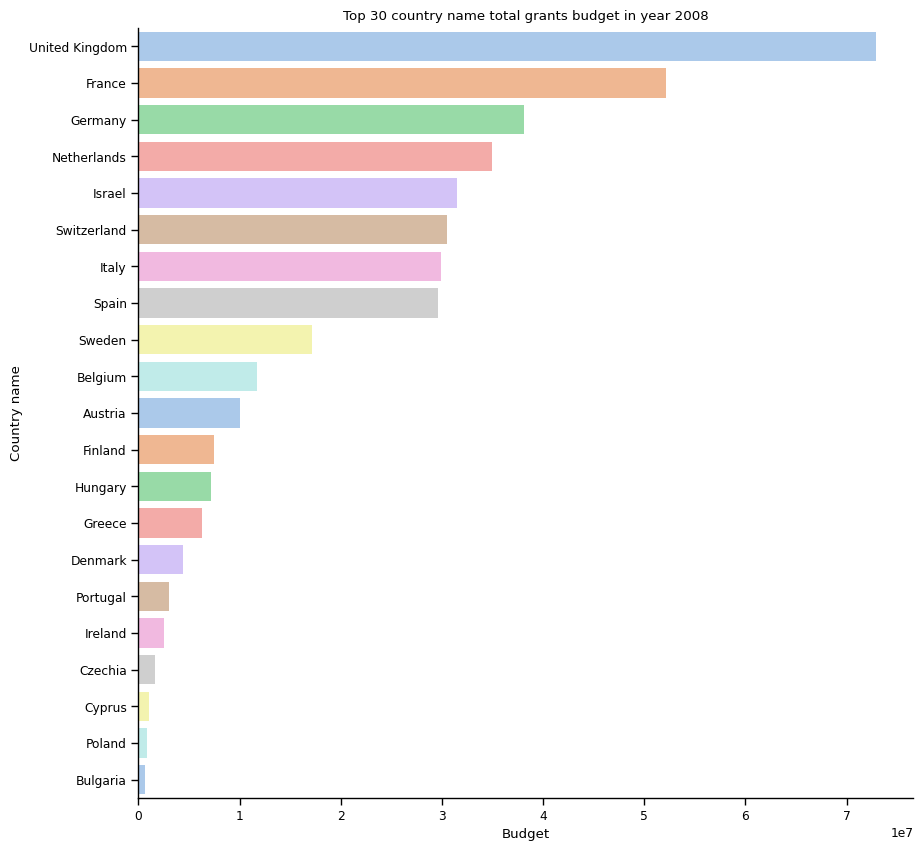

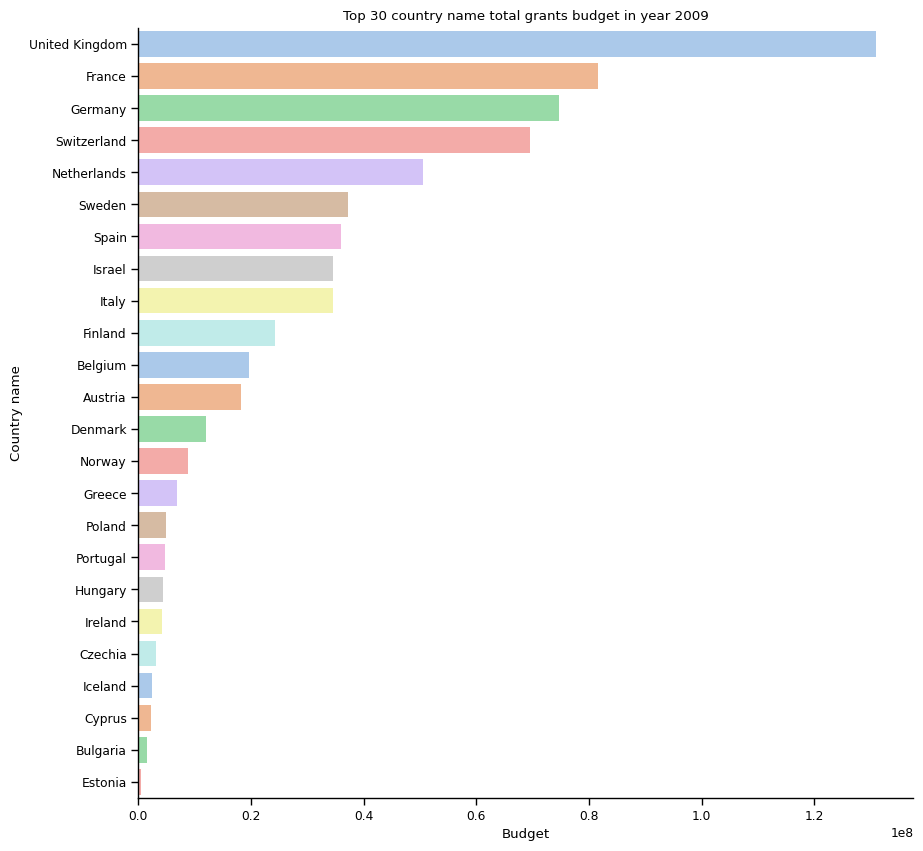

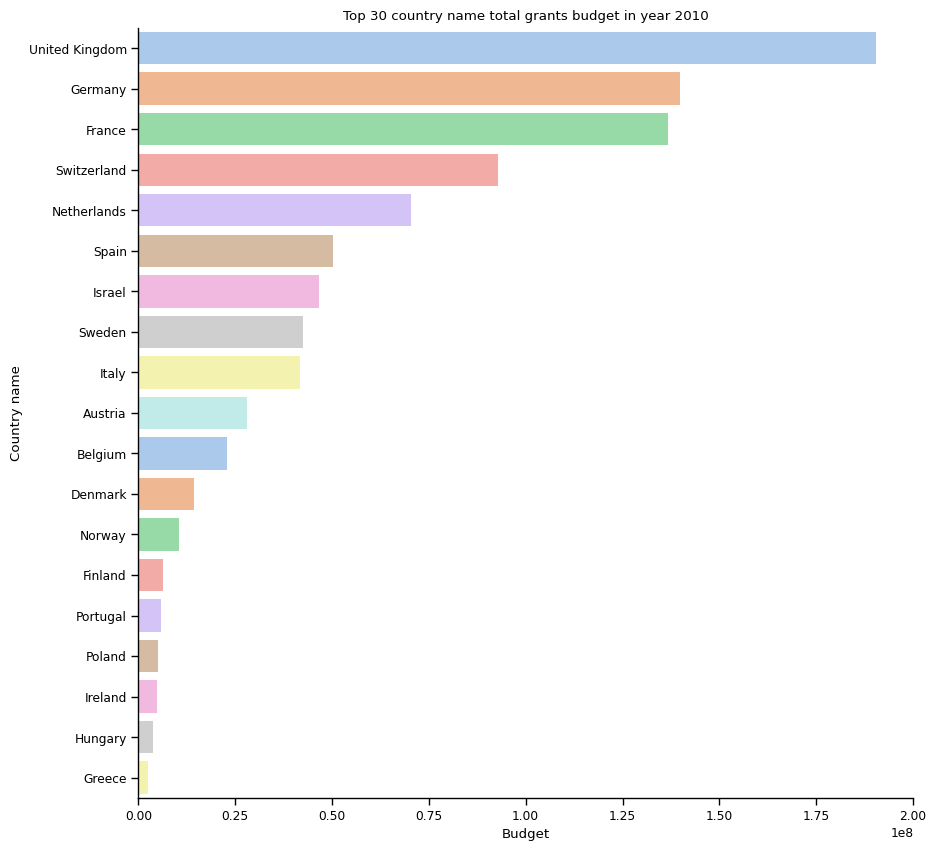

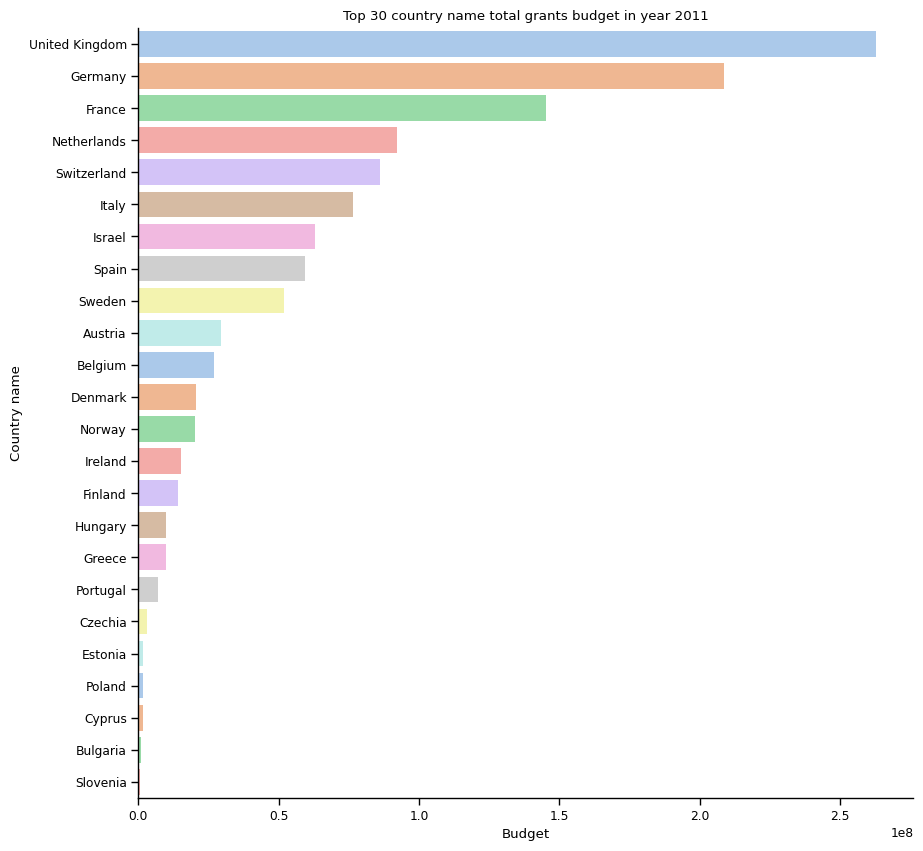

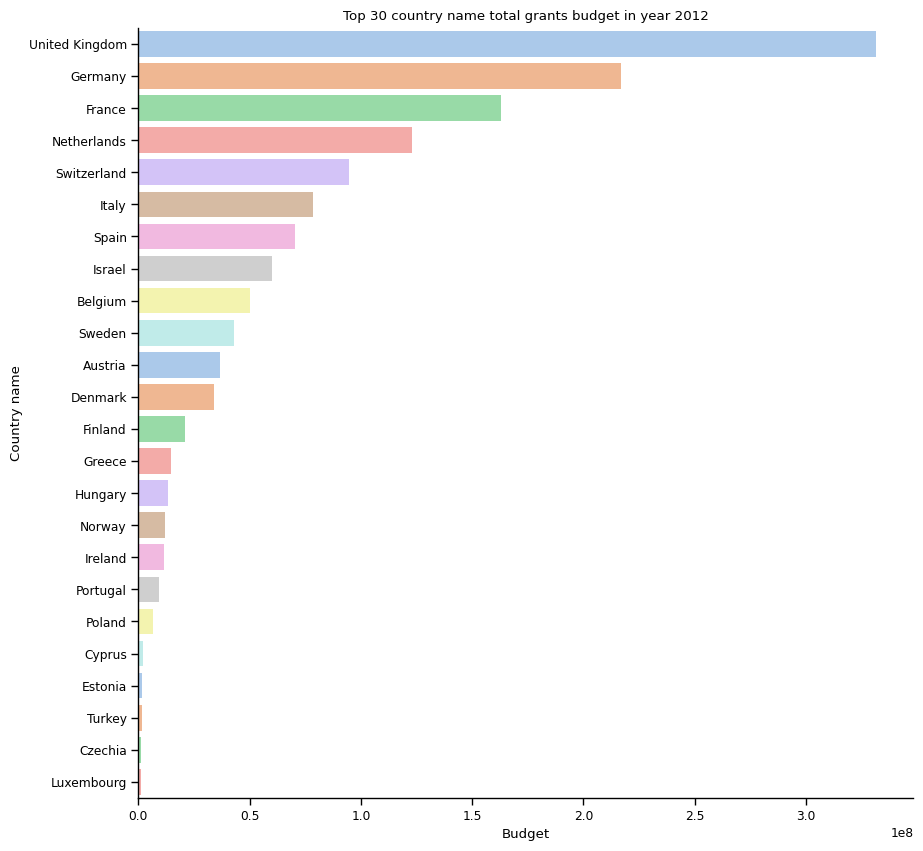

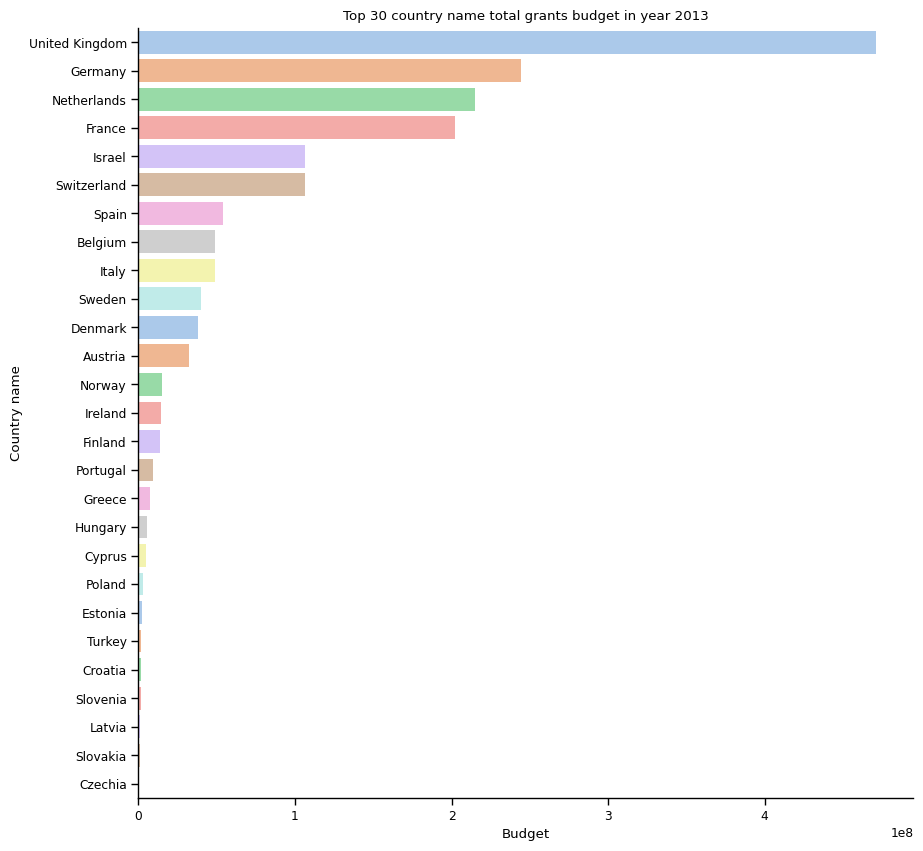

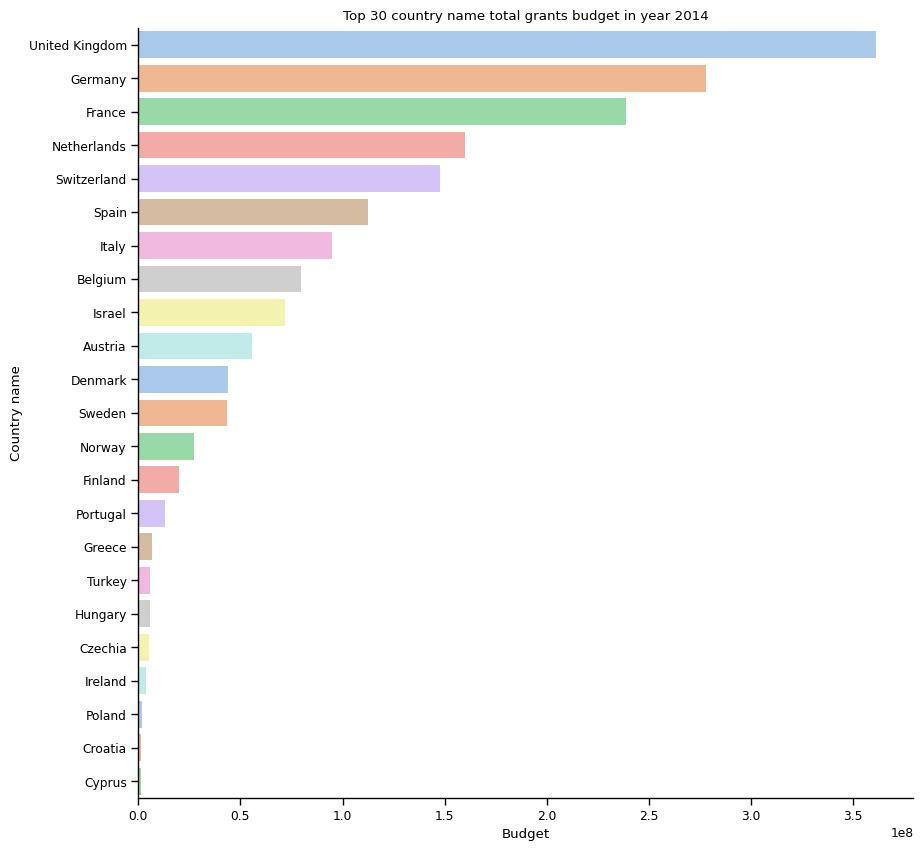

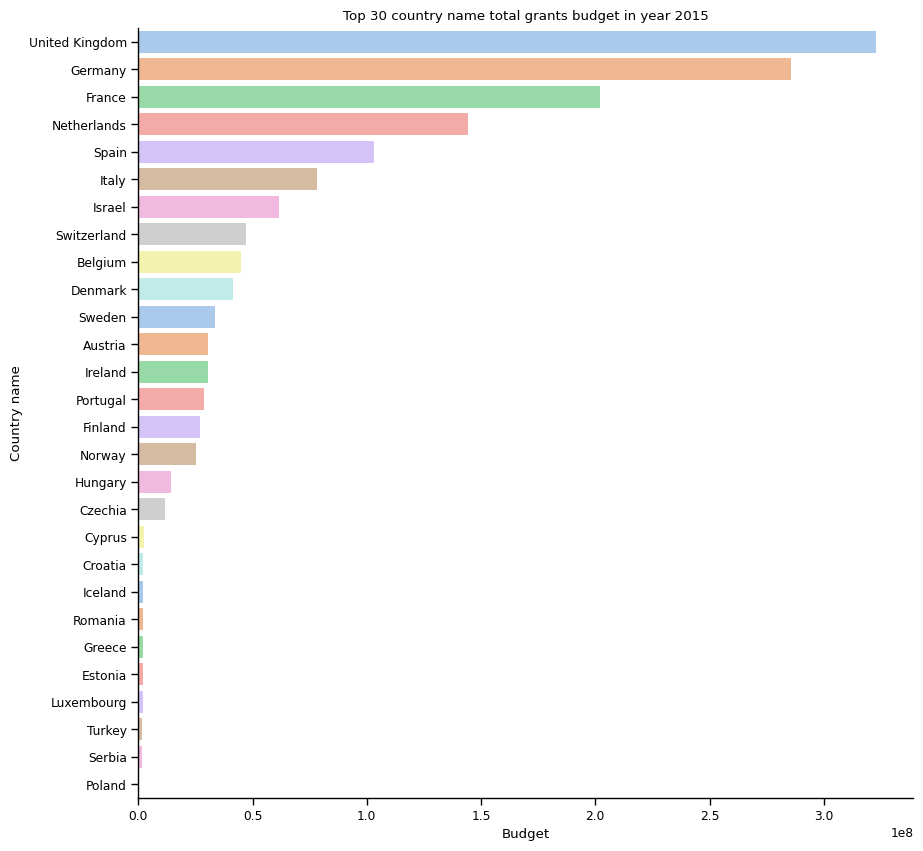

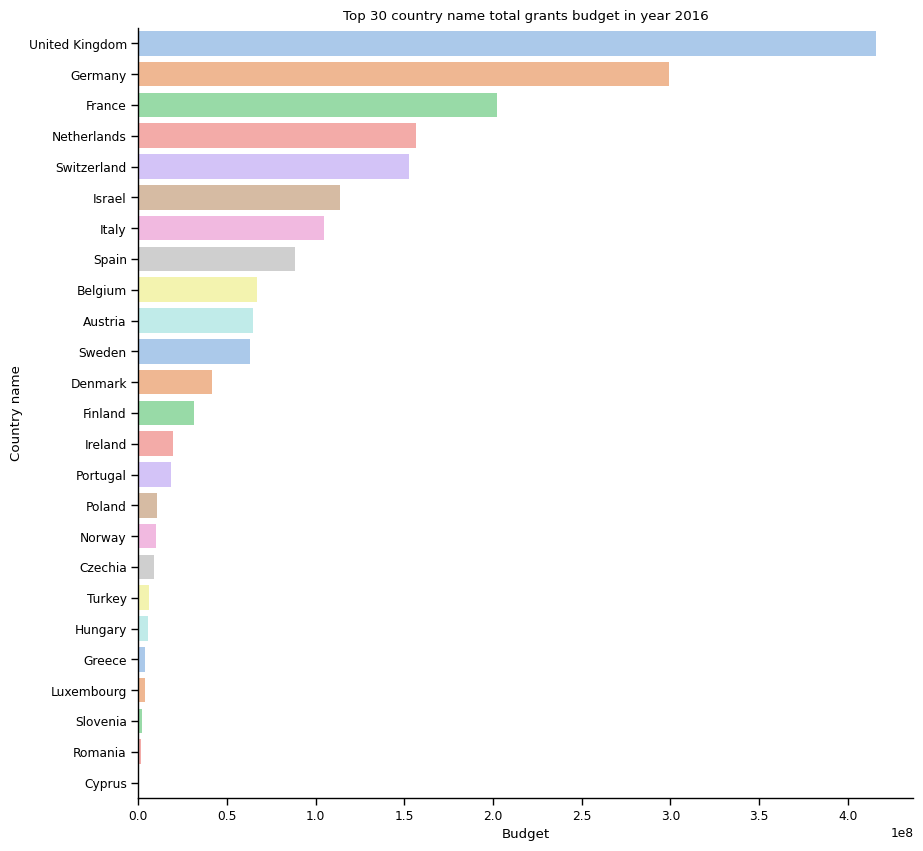

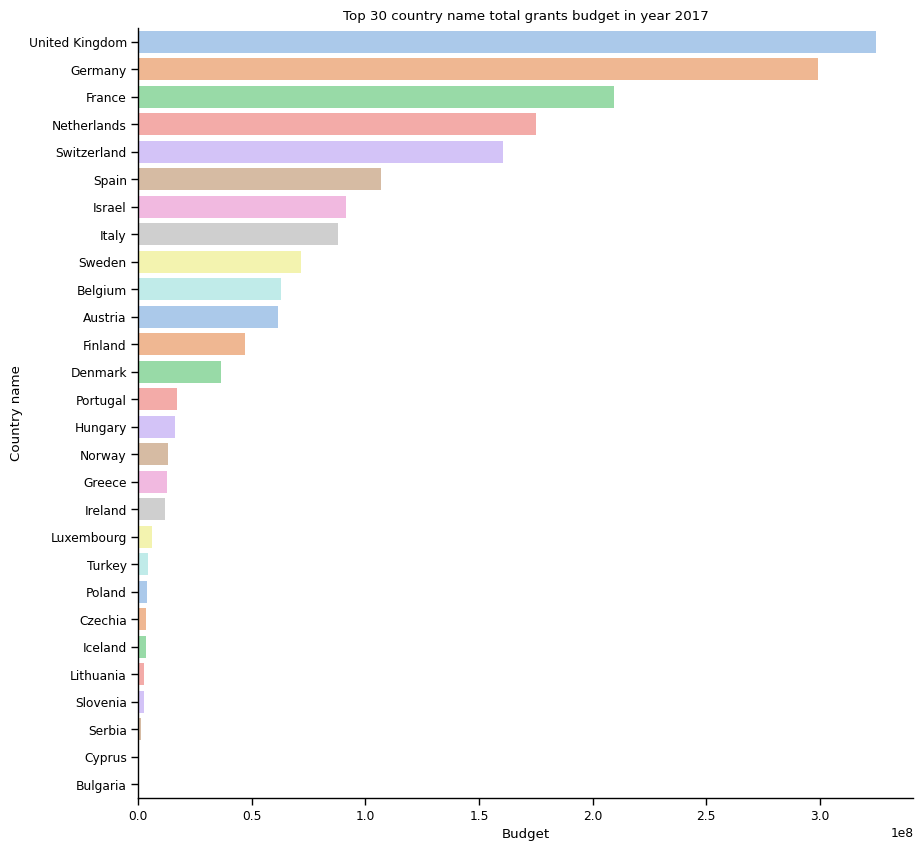

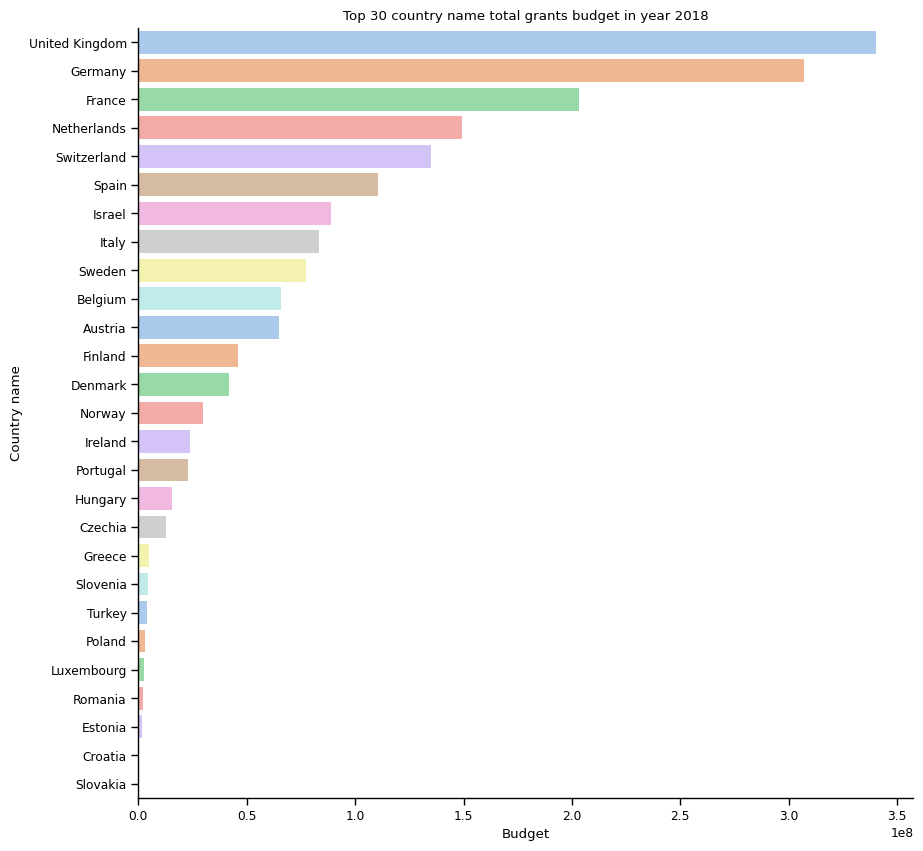

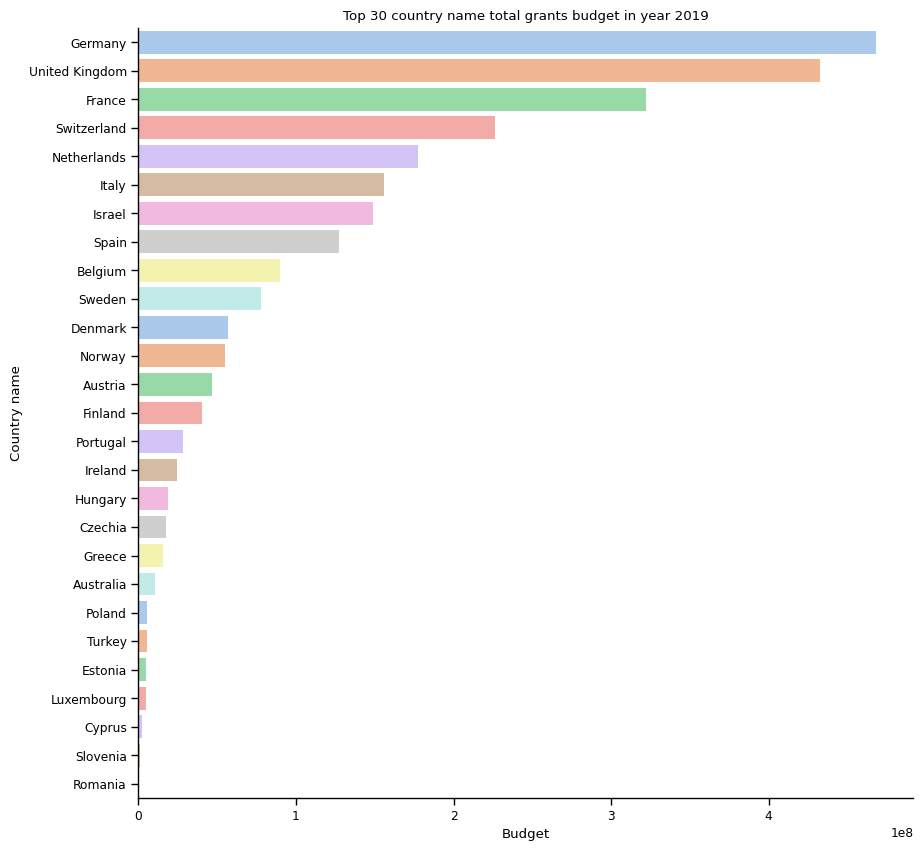

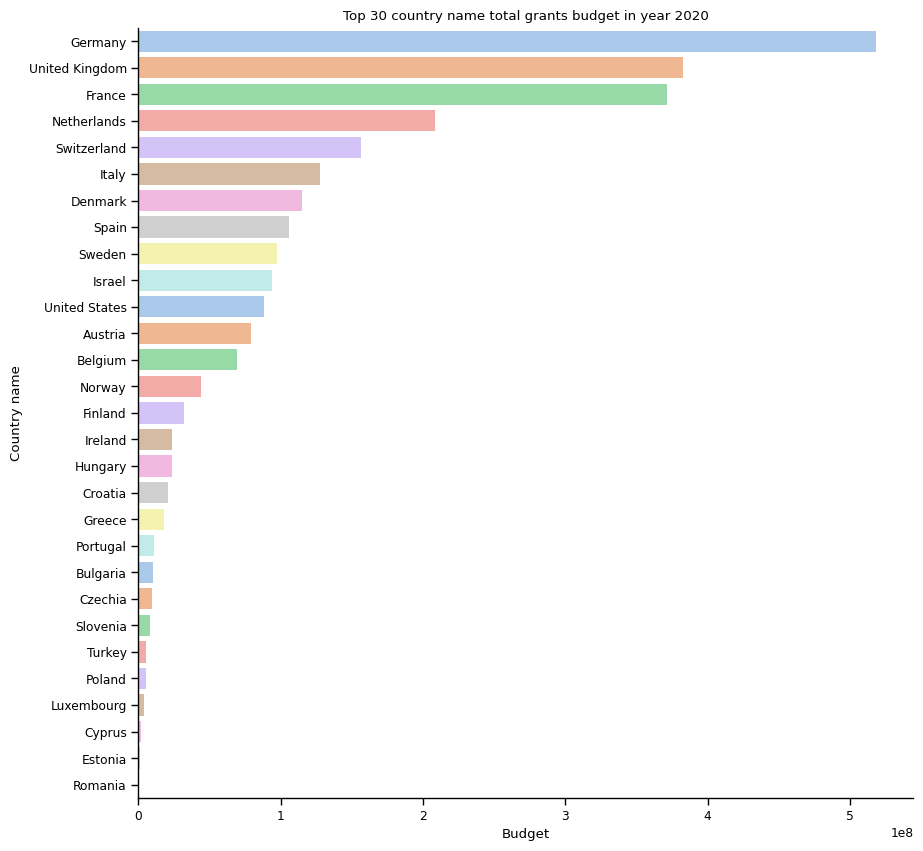

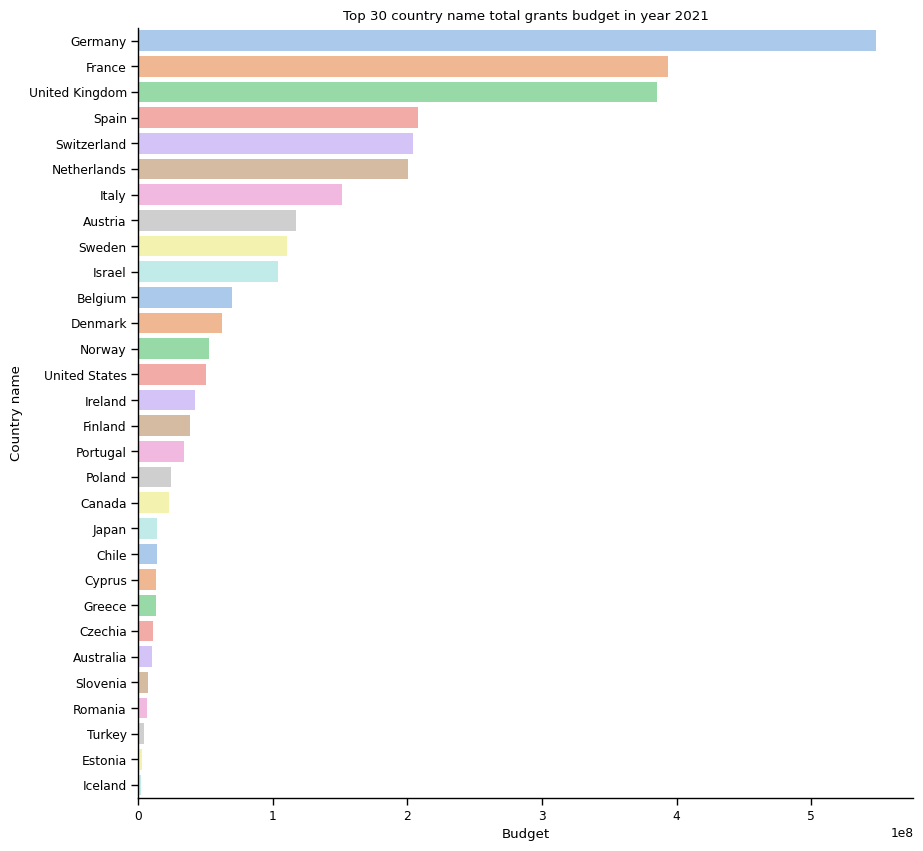

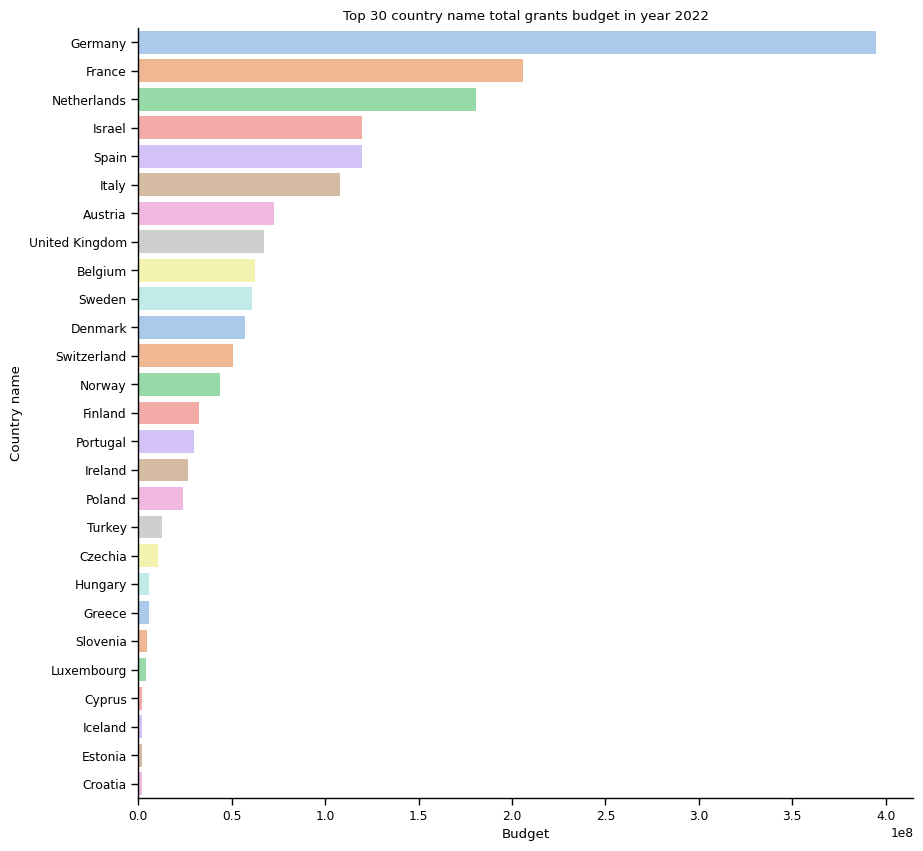

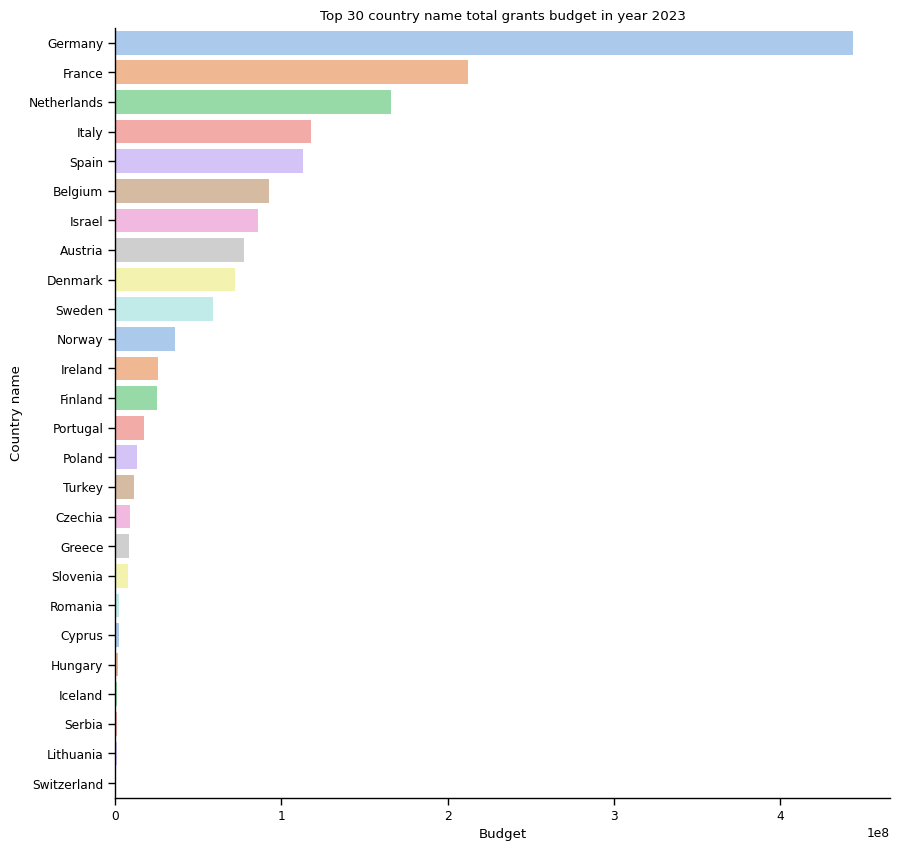

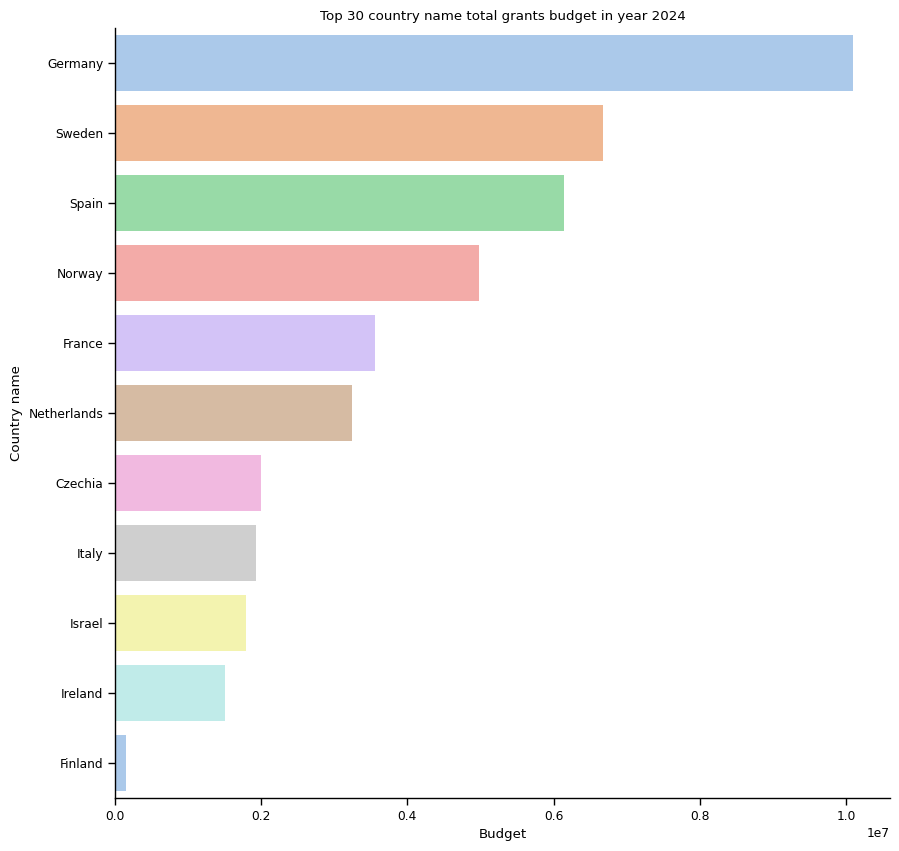

In [33]:
# Plot grants budget by grant country each year
for year in np.sort(erc_full_df["start_year"].unique()):
  loop_erc_full_df = erc_full_df[erc_full_df["start_year"] == year]
  column = "Country name"
  top_k = 30
  fig, ax = plt.subplots(figsize=(10, 10))
  ax = sns.barplot(
      loop_erc_full_df, y=column, x="Project budget",
      order=loop_erc_full_df.groupby(
          [column]
      )["Project budget"].sum().sort_values(ascending=False).iloc[:top_k].index,
      palette="pastel", errorbar=None, estimator=sum
  )
  plt.xlabel("Budget")
  sns.despine()
  plt.title(f"Top {top_k} {column.lower()} total grants budget in year {year}")
  plt.show()

Let's visualize the topic by grant type:

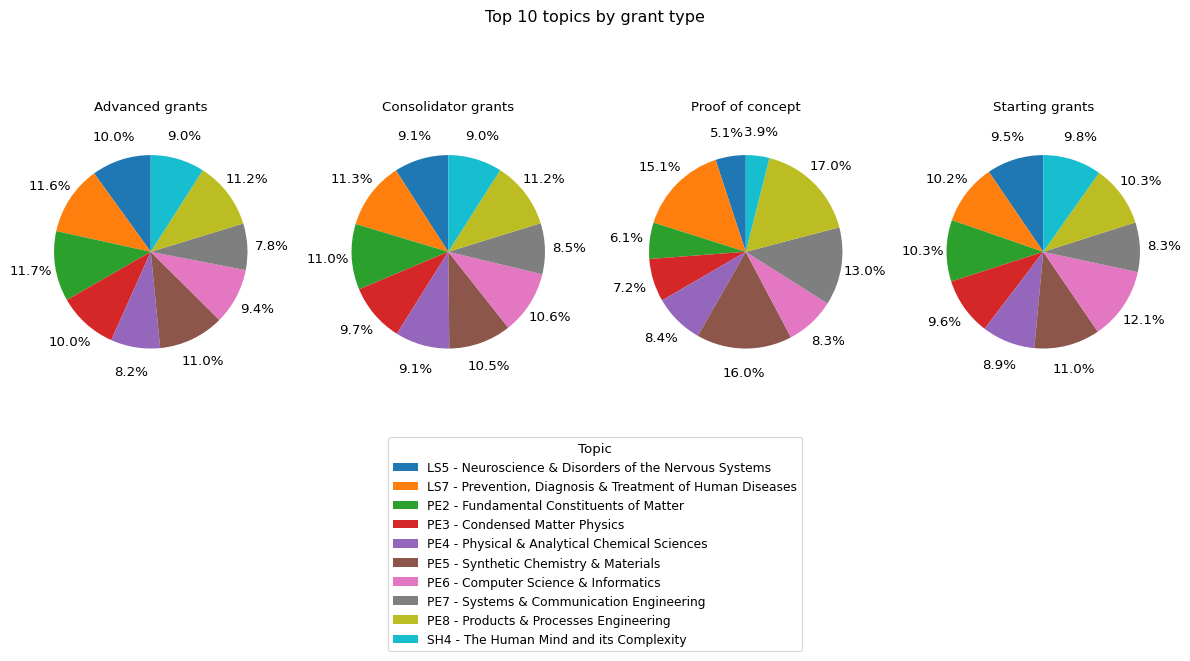

In [34]:
# Plot the topic by grant type
TOP_K=10
top_k_topic = erc_full_df.groupby("Topic")["Topic"].count().sort_values(ascending=False)[:TOP_K]
top_k_topic_l = top_k_topic.index.tolist()
top_k_topic_df = erc_full_df[erc_full_df["Topic"].isin(top_k_topic_l)]

grouped = top_k_topic_df.groupby(["Grant type", "Topic"]).size().unstack()
num_types = grouped.shape[0]
fig, axs = plt.subplots(1, num_types, figsize=(12, 6), sharey=True)

for i, type_ in enumerate(grouped.index):
    data = grouped.loc[type_].dropna()
    wedges, text_autopct, _ = axs[i].pie(data, labels=None, startangle=90, autopct="%1.1f%%", pctdistance=1.25)
    axs[i].set_title(type_, pad=15)

fig.suptitle(f"Top {TOP_K} topics by grant type")
fig.legend(wedges, grouped.columns, title="Topic", loc="lower center", bbox_to_anchor=(0.5, -0.1))
plt.tight_layout(rect=[0, -0.1, 1, 1.3])
plt.show()

Let's visualize the host institution by grant type:

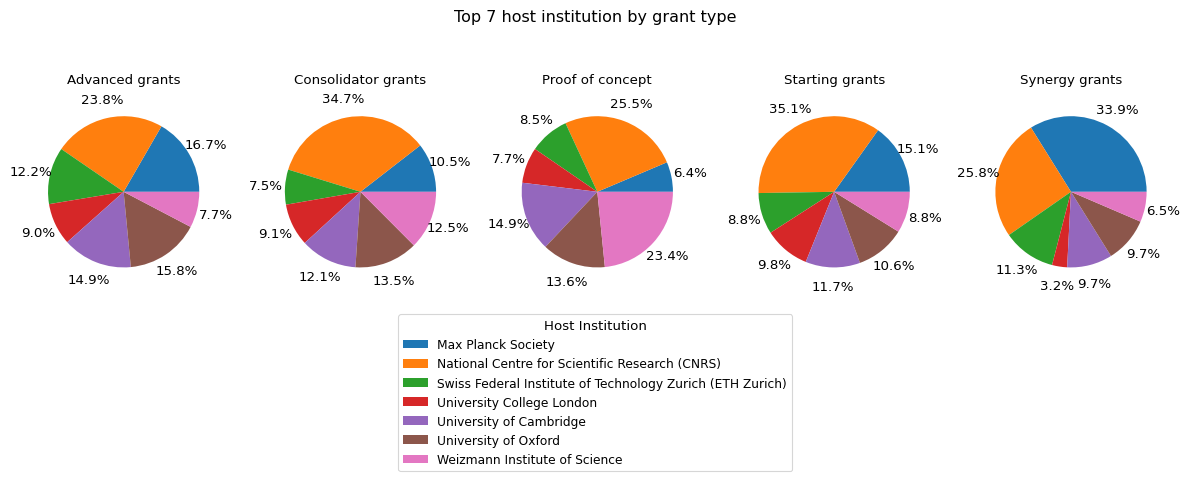

In [35]:
# Plot the host institution by grant type
TOP_K=7
column = "Host Institution"
top_k_topic = erc_full_df.groupby(column)[column].count().sort_values(ascending=False)[:TOP_K]
top_k_topic_l = top_k_topic.index.tolist()
top_k_topic_df = erc_full_df[erc_full_df[column].isin(top_k_topic_l)]

grouped = top_k_topic_df.groupby(["Grant type", column]).size().unstack()
num_types = grouped.shape[0]
fig, axs = plt.subplots(1, num_types, figsize=(12, 6), sharey=True)

for i, type_ in enumerate(grouped.index):
    data = grouped.loc[type_].dropna()
    wedges, text_autopct, _ = axs[i].pie(data, labels=None, startangle=0, autopct="%1.1f%%", pctdistance=1.25)
    axs[i].set_title(type_, pad=10)

fig.suptitle(f"Top {TOP_K} host institution by grant type")
fig.legend(wedges, grouped.columns, title=column, loc="lower center", bbox_to_anchor=(0.5, 0.2))
plt.tight_layout(rect=[0, -0.1, 1, 1.5])
plt.show()

Let's visualize the Country by grant type:

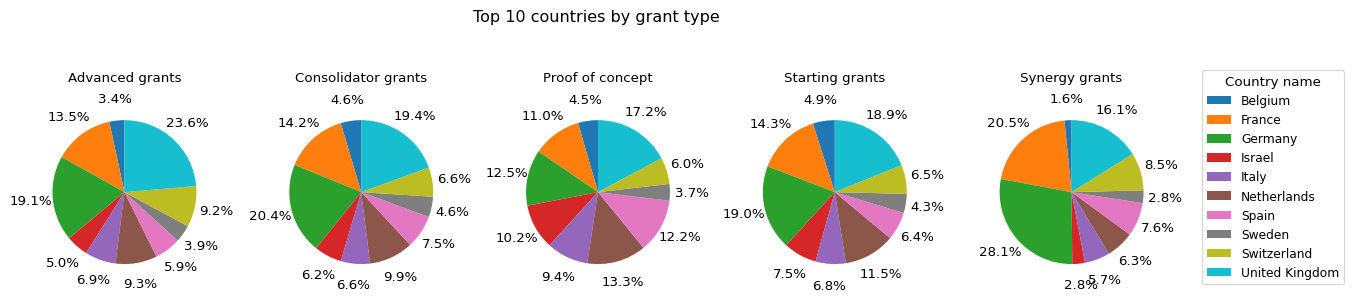

In [36]:
# Plot the countries by grant type
TOP_K=10
column = "Country name"
top_k_topic = erc_full_df.groupby(column)[column].count().sort_values(ascending=False)[:TOP_K]
top_k_topic_l = top_k_topic.index.tolist()
top_k_topic_df = erc_full_df[erc_full_df[column].isin(top_k_topic_l)]

grouped = top_k_topic_df.groupby(["Grant type", column]).size().unstack()
num_types = grouped.shape[0]
fig, axs = plt.subplots(1, num_types, figsize=(12, 6), sharey=True)

for i, type_ in enumerate(grouped.index):
    data = grouped.loc[type_].dropna()
    wedges, text_autopct, _ = axs[i].pie(data, labels=None, startangle=90, autopct="%1.1f%%", pctdistance=1.3)
    axs[i].set_title(type_, pad=15)

fig.suptitle(f"Top {TOP_K} countries by grant type")
fig.legend(wedges, grouped.columns, title=column, loc="center left", bbox_to_anchor=(1, 0.7))
plt.tight_layout(rect=[0, -0.1, 1, 1.5])
plt.show()

## ***Network analysis***

Let's create a graph of all the collaboration in the ERC:

In [37]:
# Create graph of collaboration projects
collaboration_projects_ids = erc_full_df[
    erc_full_df.duplicated(subset="Project number",
                           keep=False)]["Project number"].unique()
projects_id_2_Institution = {}
for idx, projects_id in enumerate(collaboration_projects_ids):
  curr_df = erc_full_df[erc_full_df["Project number"].isin([projects_id])]
  projects_id_2_Institution[projects_id] = curr_df["Host Institution"].to_list()
collaboration_institutions_l = []
for project_id, institutions in projects_id_2_Institution.items():
  combinations_list = list(combinations(institutions, 2))
  {
      collaboration_institutions_l.extend(
          [
              dict(institution_1=institution_1, institution_2=institution_2),
          ]
      ) for institution_1, institution_2 in combinations_list
  }
G = nx.Graph()
for edge_dict in collaboration_institutions_l:
  source = edge_dict["institution_1"]
  target = edge_dict["institution_2"]
  value = 1

  if G.has_edge(source, target):
    current_weight = G[source][target]["weight"]
    G[source][target]["weight"] = current_weight + value
  elif G.has_edge(target, source):
    current_weight = G[target][source]["weight"]
    G[target][source]["weight"] = current_weight + value
  else:
    G.add_edge(source, target, weight=value)
plt.figure(figsize=(100, 100))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)
plt.axis("off")
plt.title("Graph of collaboration projects")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's visualize the number of PI's in a collaboration:

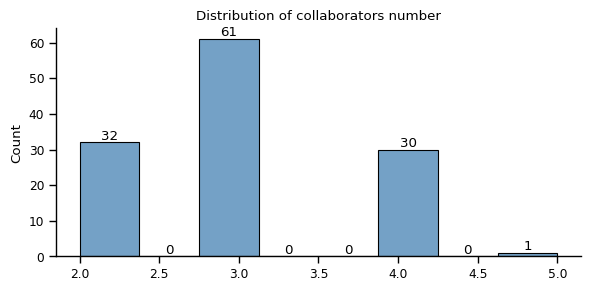

In [38]:
# Plot number of PI's in a collaboration:
fig, ax = plt.subplots(figsize=(6, 3))
ax = sns.histplot(
    [len(d) for d in list(projects_id_2_Institution.values())],
    ax=ax, color="steelblue"
)
ax.bar_label(ax.containers[0])
plt.title("Distribution of collaborators number")
sns.despine()
plt.tight_layout()
plt.show()

Let's get all cliques in the graph:

In [39]:
# Find all cliques in the graph
cliques = list(nx.find_cliques(G))
sorted_cliques = sorted(cliques, key=len, reverse=True)
for clique in sorted_cliques:
    print(clique)

['University of Paris 7 - Diderot', 'Radboud University Nijmegen', 'Maastricht University', 'UNIVERSITE PARIS 13', 'University Grenoble Alpes']
['University of Reading', 'Foundation for Research and Technology Hellas', 'University of Stuttgart', 'University of Freiburg']
['University of Copenhagen', 'University of York', 'University of Exeter', 'University of Mainz']
['Athens University of Economics and Business - Research Center', 'University of Cyprus', 'KWR Water Research Institute', 'Bielefeld University']
['Complutense University of Madrid', 'Centre for Genomic Regulation', 'National Centre for Scientific Research (CNRS)', 'University College London']
['University of Paris 7 - Diderot', 'University of Bonn', 'French College', 'University of Paris 11']
['University of Munich (LMU)', 'University of Delaware', 'Vienna University of Technology', 'National Metrology Institute of Germany (PTB)']
['Bulgarian Academy of Sciences', 'Central European University', 'Charite - University Hospi

Let's visualize first clique:

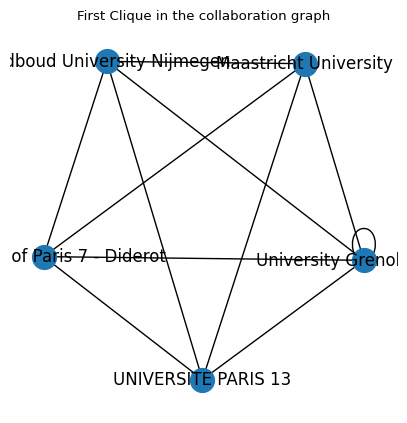

In [40]:
# Plot first clique
first_clique = sorted_cliques[0]
subgraph = G.subgraph(first_clique)
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(subgraph)

nx.draw_networkx_nodes(subgraph, pos)
nx.draw_networkx_edges(subgraph, pos)
nx.draw_networkx_labels(subgraph, pos)

plt.axis("off")
plt.title("First Clique in the collaboration graph")
plt.show()


Let's visualize graph with communities:

In [41]:
# Plot graph with communities
communities = nx.algorithms.community.greedy_modularity_communities(G)
communities_dict = {}
for i, community in enumerate(communities):
  for node in community:
    communities_dict[node] = i

unique_communities = set(communities_dict.values())
pos = nx.spring_layout(G)
plt.figure(figsize=(100, 100))

for community_id in unique_communities:
  nodes_in_community = [
      node for node, comm_id in communities_dict.items()
      if comm_id == community_id
  ]
  nx.draw_networkx_nodes(
      G, pos, nodelist=nodes_in_community, node_color=f'C{community_id}',
      label=f'Community {community_id}'
  )
  nx.draw_networkx_labels(
      G, pos, labels={node: node for node in nodes_in_community}
  )

nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.title('Graph with Communities')
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## ***Geographical analysis***

Let's visualize the budget per country in each year:

In [42]:
curr_col = 'Country name'
date_column = 'start_year'
CRITIRA_VALUE = 'Project budget' # Project budget/cumulative_sum

erc_full_df.sort_values(by=[curr_col, date_column], ascending=[True,True])
grouped_budget_df = erc_full_df.groupby([curr_col, date_column])['Project budget'].sum().reset_index()
grouped_budget_df['cumulative_sum'] = grouped_budget_df.groupby(curr_col)['Project budget'].cumsum()

print(grouped_budget_df.head(10))

# map plot
min_range_color = 0 # int(grouped_meteorite_df[CRITIRA_VALUE].min())
max_range_color = int(grouped_budget_df[CRITIRA_VALUE].max())

from_year = int(grouped_budget_df[date_column].min())
to_year = int(grouped_budget_df[date_column].max())

title=f"Country's cumulative budget from {from_year} to {to_year} W animation_frame"
print(title)
print()

fig = px.choropleth(grouped_budget_df, locations=curr_col,locationmode='country names',
                    color=f'{CRITIRA_VALUE}',
                    animation_frame=date_column,
                    color_continuous_scale='Reds',
                    range_color=(min_range_color, max_range_color),
                    title=title
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

  Country name  start_year  Project budget  cumulative_sum
0    Australia        2019      10400695.0      10400695.0
1    Australia        2021       9999892.0      20400588.0
2      Austria        2008      10088797.0      10088797.0
3      Austria        2009      18225044.0      28313840.0
4      Austria        2010      28161056.0      56474896.0
5      Austria        2011      29278052.0      85752944.0
6      Austria        2012      36680368.0     122433312.0
7      Austria        2013      32410580.0     154843904.0
8      Austria        2014      55772408.0     210616304.0
9      Austria        2015      30563792.0     241180096.0
Country's cumulative budget from 2008 to 2024 W animation_frame



## ***NLP analysis***

Let's get model for embedding creation:

In [43]:
# Initialize the tokenizer, configuration, and model from the
# 'cerebras/Cerebras-GPT-111M' checkpoint
# thenlper/gte-base
tokenizer = AutoTokenizer.from_pretrained('thenlper/gte-base')
config = AutoConfig.from_pretrained('thenlper/gte-base')
model = AutoModel.from_pretrained('thenlper/gte-base')

# Check if CUDA (GPU) is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device is: {device}')
model = model.to(device)

Device is: cuda


In [44]:
!nvidia-smi

Mon Aug 14 10:08:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |   1353MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's define some helper methods:

In [45]:
def size_normalization(arr:np.ndarray, new_min: int = 10, new_max:int = 1000) -> np.ndarray:
  """Normalize the values in an array to a specified range.

    Parameters:
        arr (np.ndarray): The input array to be normalized.
        new_min (int): The new minimum value for the normalized array. Default is 10.
        new_max (int): The new maximum value for the normalized array. Default is 1000.

    Returns:
        np.ndarray: The normalized array with values scaled to the specified range.
  """
  normalized_arr = (
      (arr - np.min(arr)) / (np.max(arr) - np.min(arr))) * (
          new_max - new_min) + new_min
  return normalized_arr


def text_inference(text: str) -> np.ndarray:
  """Perform inference on a given text and get its embeddings.

  Parameters:
      text (str): The input text.

  Returns:
      np.ndarray: The embeddings of the text obtained from the model.
  """
  encoding = tokenizer(text, truncation=True, return_tensors="pt")
  encoding.to(device)
  with torch.no_grad():
    outputs=model(**encoding)
    text_embeddings= outputs.last_hidden_state.sum(
        dim=[0,1]).cpu().detach().numpy()
  del encoding
  return text_embeddings


Let's create embeddings of the abstract:

In [46]:
# select non-empty abstracts and compute their embeddings
abstract_dataset = erc_full_df[~erc_full_df['Abstract'].isna()]
abstract_embeddings_np = []
for abstract in tqdm(abstract_dataset.Abstract.values):
  abstract_embeddings_np.append(text_inference(text=abstract))
abstract_embeddings_np = np.stack(abstract_embeddings_np)
print(f"Abstract embeddings shape:", abstract_embeddings_np.shape)

  0%|          | 0/14084 [00:00<?, ?it/s]

Abstract embeddings shape: (14084, 768)


Let's create embeddings of the titles:

In [47]:
# select non-empty titles and compute their embeddings
title_dataset = erc_full_df[~erc_full_df['Project title'].isna()]
title_embeddings_np = []
for title in tqdm(title_dataset["Project title"].values):
  title_embeddings_np.append(text_inference(text=title))
title_embeddings_np = np.stack(title_embeddings_np)
print(f"Abstract embeddings shape:", title_embeddings_np.shape)

  0%|          | 0/14375 [00:00<?, ?it/s]

Abstract embeddings shape: (14375, 768)


Let's visualize the abstract embeddings in relation to money (size) and topic (color):

In [48]:
tsne = TSNE(n_components=2)
tsne_abstract_result = tsne.fit_transform(abstract_embeddings_np)

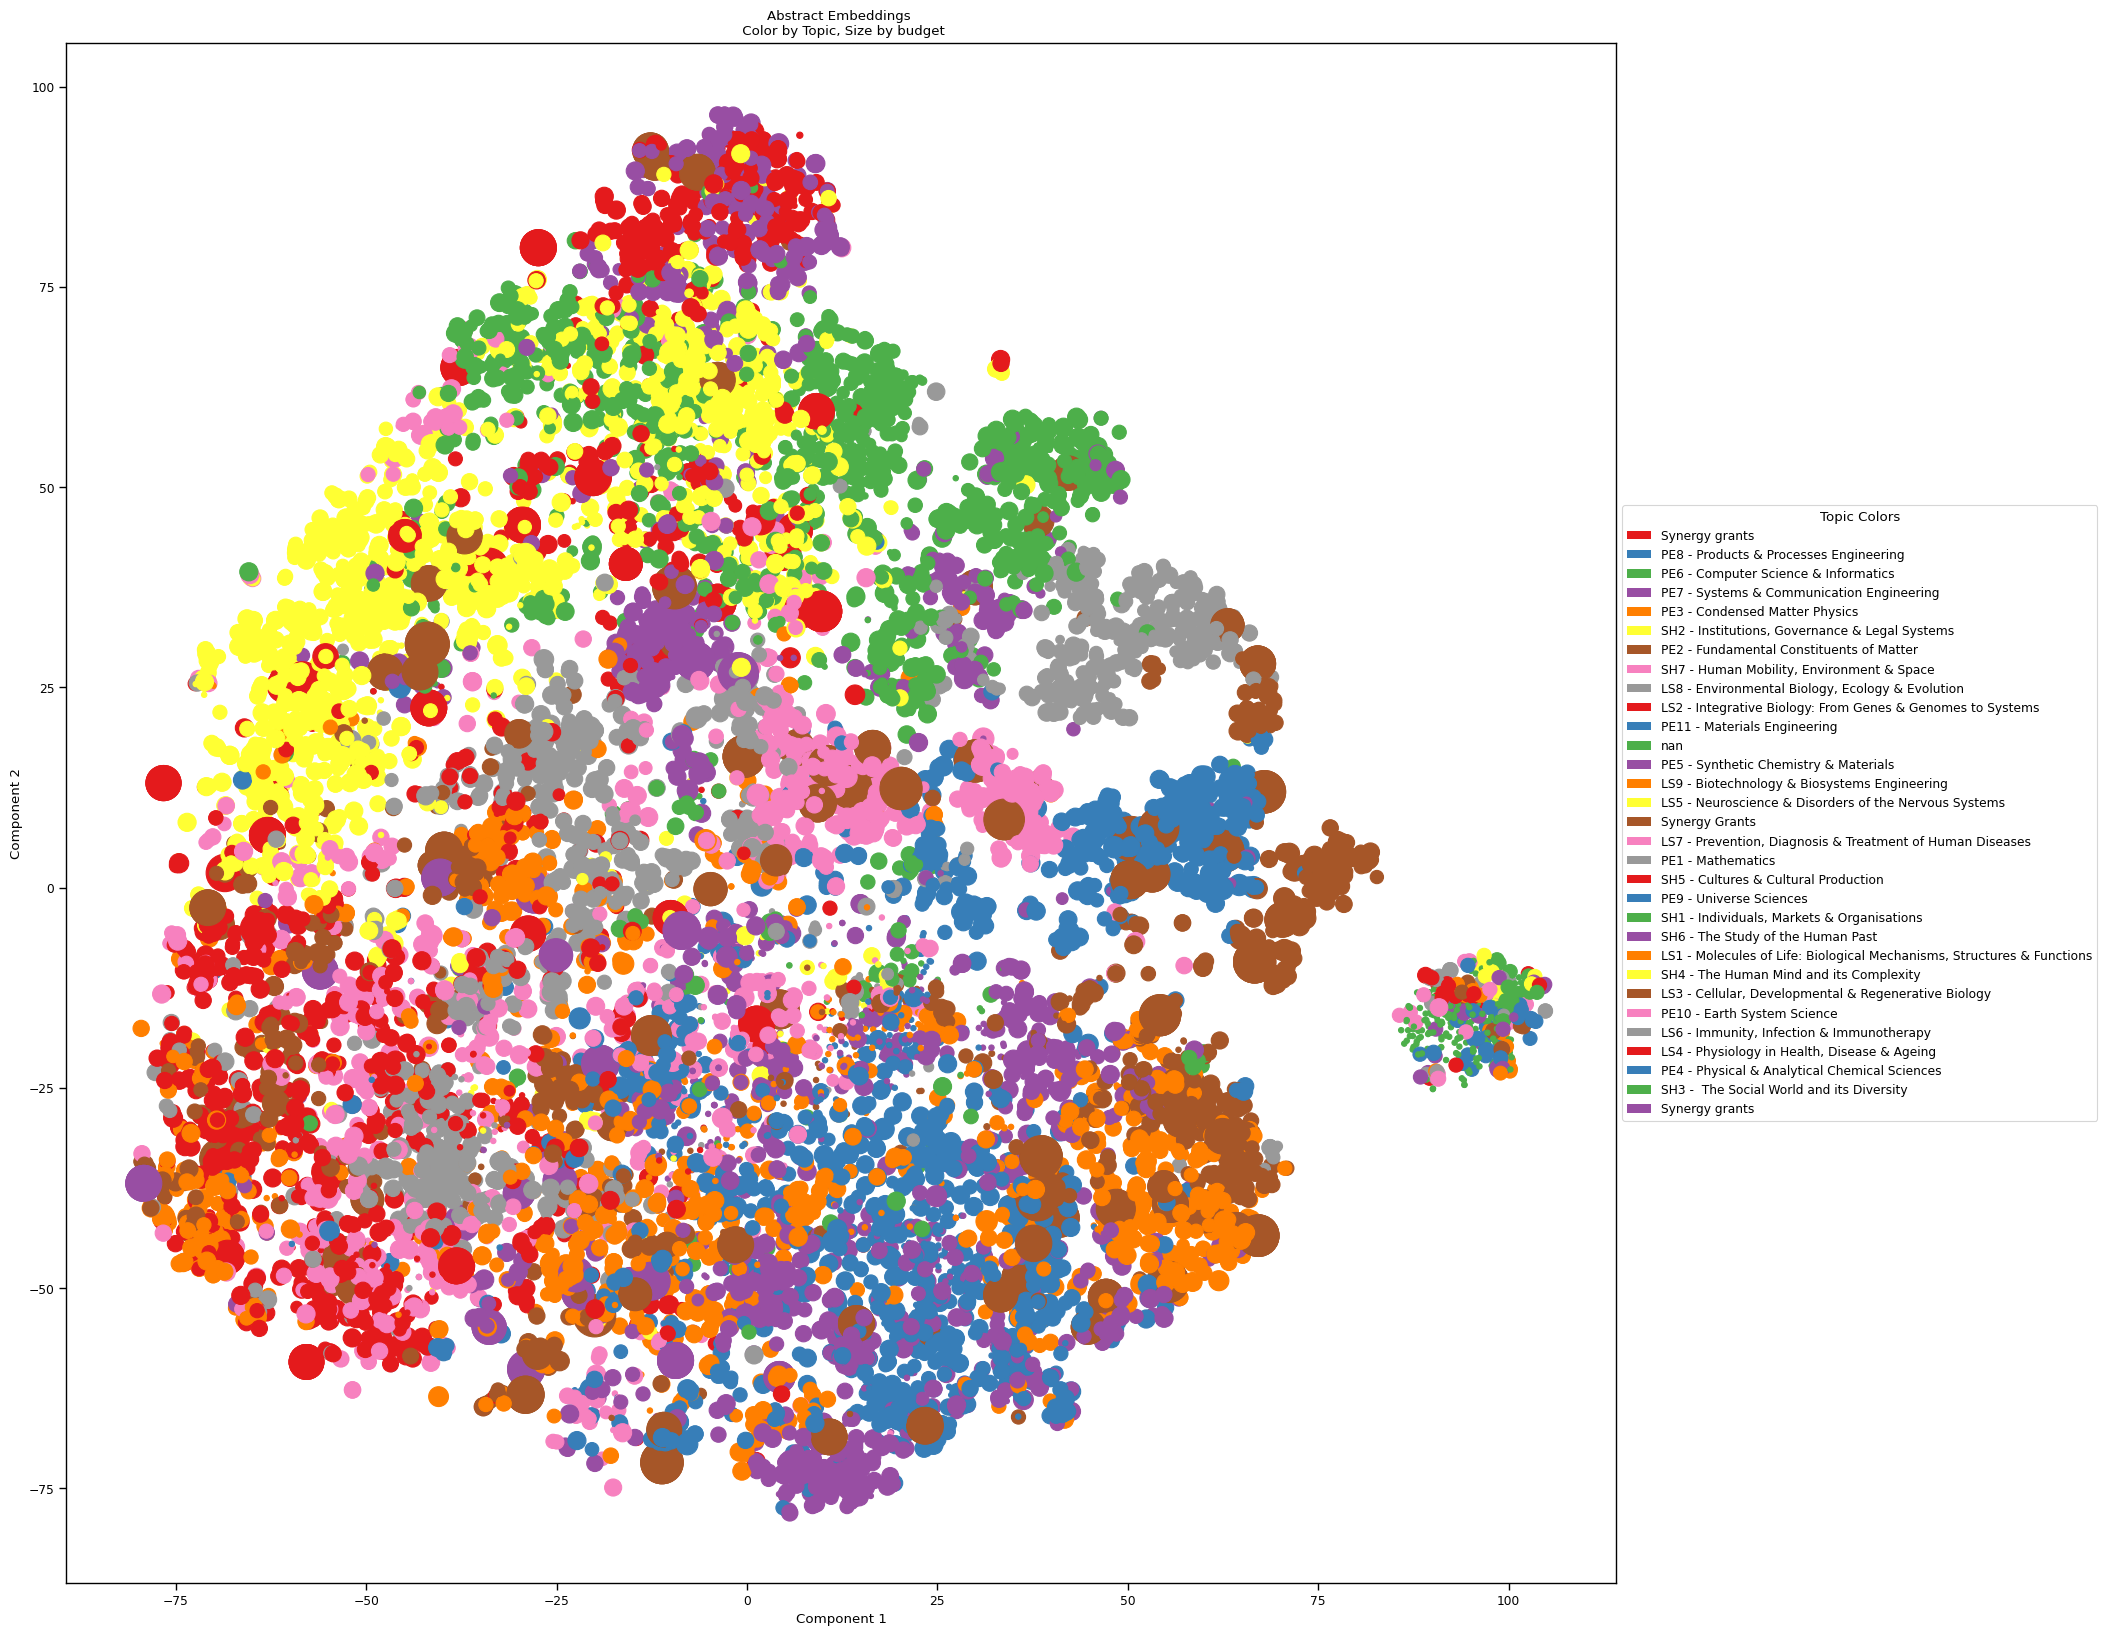

In [49]:
unique_topic = abstract_dataset.Topic.unique()
unique_topic_color_palette = sns.color_palette('Set1', n_colors=len(unique_topic))
topic_2_color = {topic:c for topic,c in list(zip(unique_topic, unique_topic_color_palette))}
colors_by_unique_topic = abstract_dataset.Topic.apply(lambda topic: topic_2_color[topic]).values


normalized_size = size_normalization(arr=abstract_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_abstract_result[:, 0], tsne_abstract_result[:, 1], s=normalized_size, color=colors_by_unique_topic)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Abstract Embeddings \n Color by Topic, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in topic_2_color.items()]
plt.legend(handles=legend_handles, title='Topic Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Let's visualize the abstract embeddings in relation to money (size) and university (color):

In [50]:
unique_university = abstract_dataset['Host Institution'].unique()
unique_university_color_palette = sns.color_palette('Set1', n_colors=len(unique_university))
university_2_color = {university:c for university,c in list(zip(unique_university, unique_university_color_palette))}
colors_by_unique_university = abstract_dataset['Host Institution'].apply(lambda university: university_2_color[university]).values


normalized_size = size_normalization(arr=abstract_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_abstract_result[:, 0], tsne_abstract_result[:, 1], s=normalized_size, color=colors_by_unique_university)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Abstract Embeddings \n Color by Host Institution, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in university_2_color.items()]
plt.legend(handles=legend_handles, title='Host Institution Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's visualize the abstract embeddings in relation to money (size) and country (color):

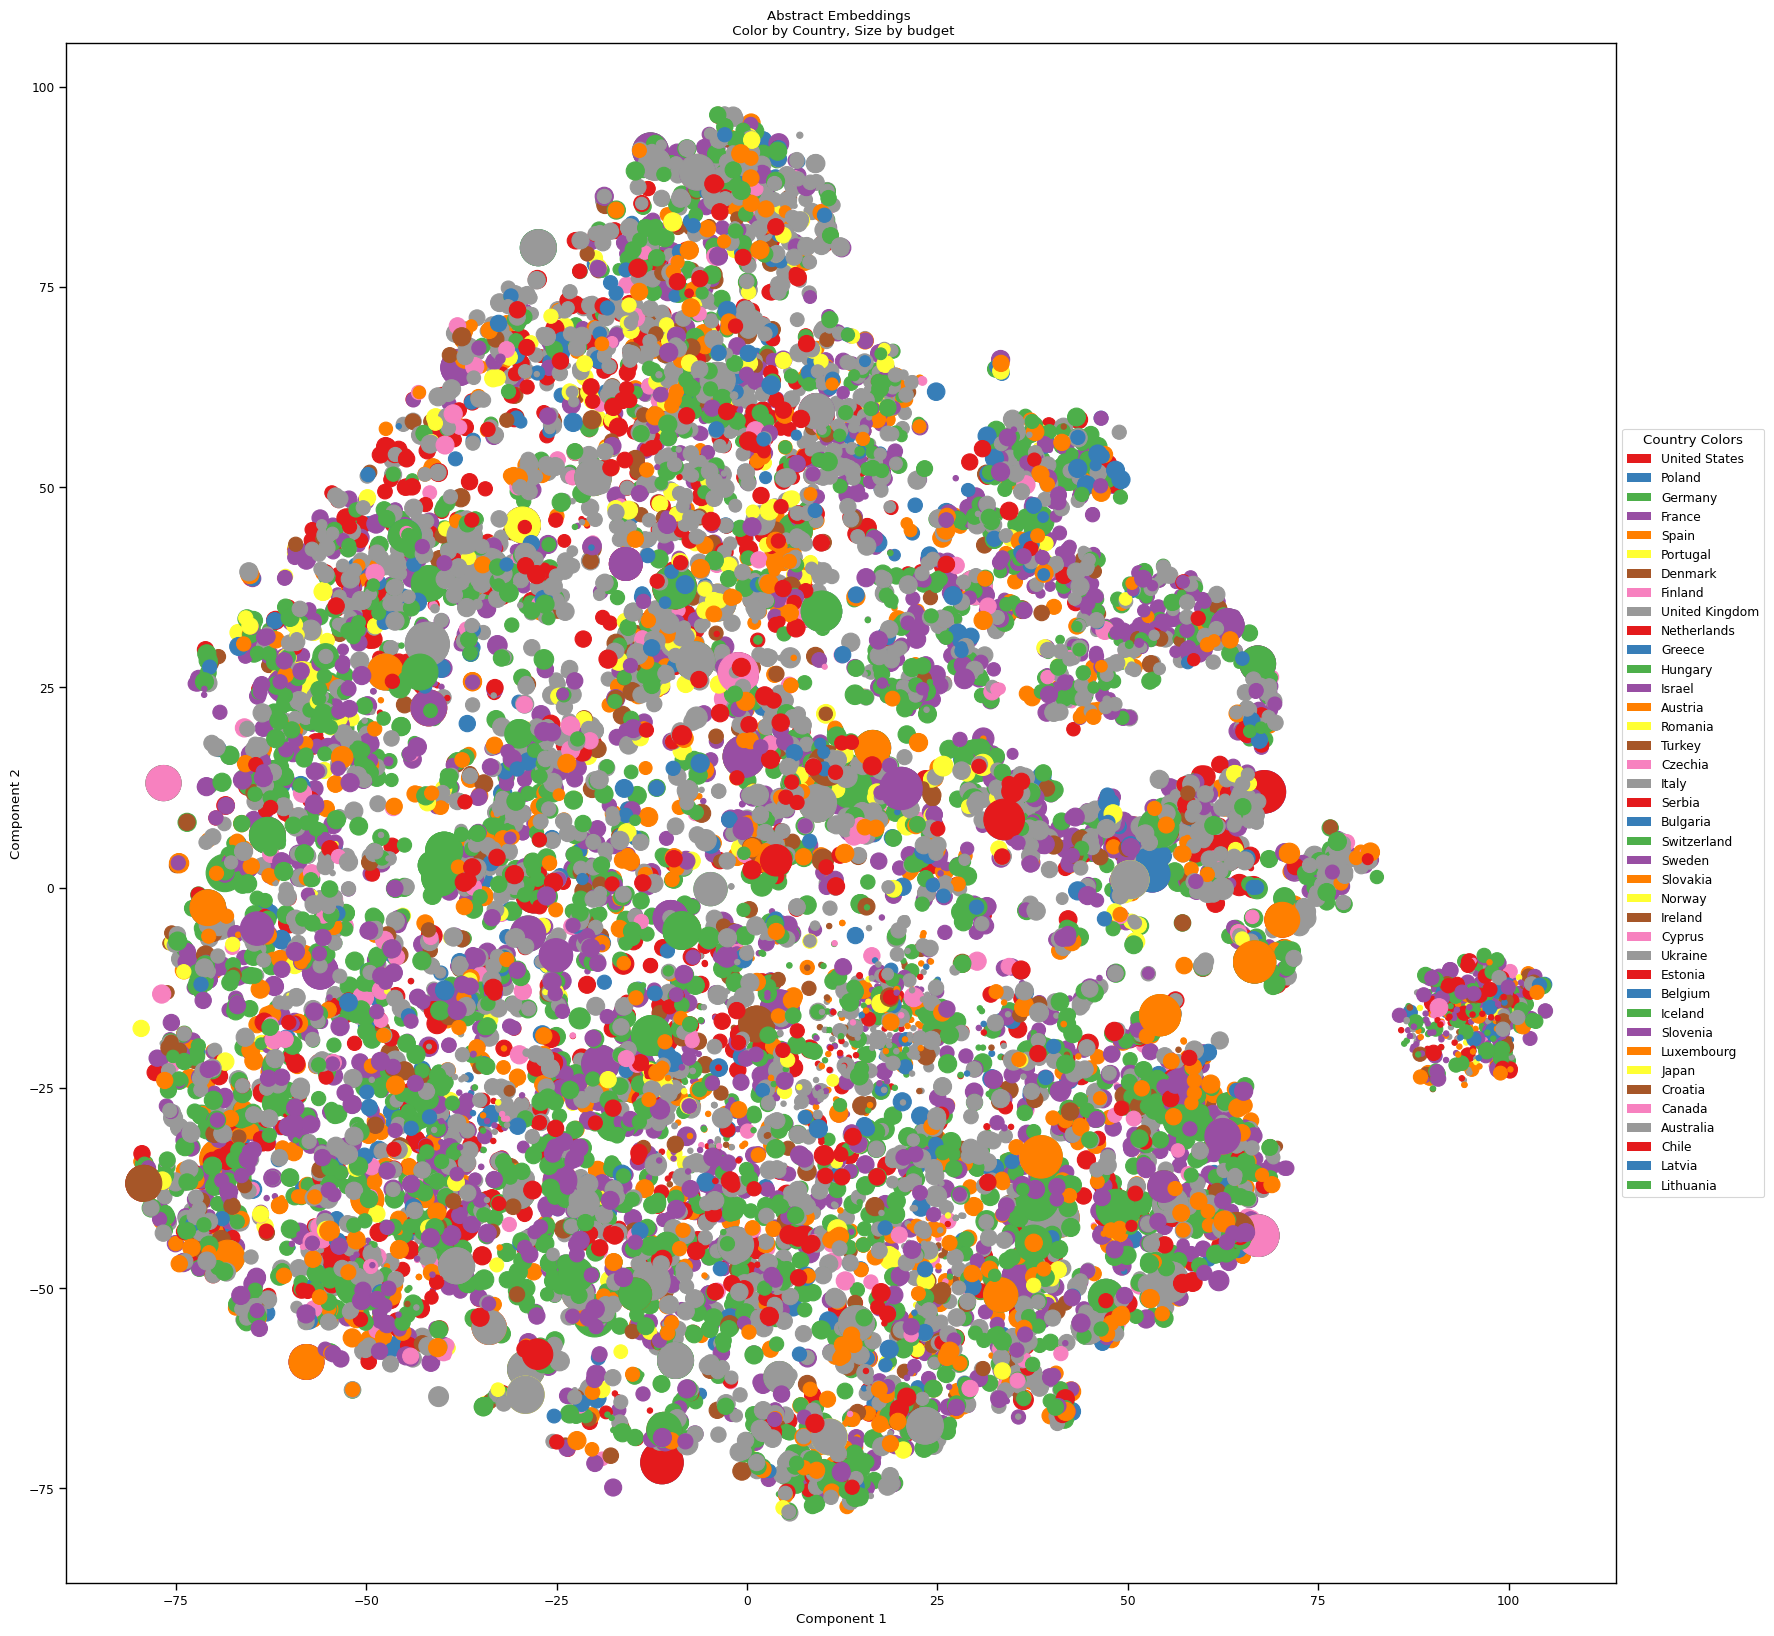

In [51]:
unique_Country_name = abstract_dataset["Country name"].unique()
unique_Country_name_color_palette = sns.color_palette('Set1', n_colors=len(unique_Country_name))
Country_name_2_color = {topic:c for topic,c in list(zip(unique_Country_name, unique_Country_name_color_palette))}
colors_by_unique_Country_name = abstract_dataset["Country name"].apply(lambda Country_name: Country_name_2_color[Country_name]).values


normalized_size = size_normalization(arr=abstract_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_abstract_result[:, 0], tsne_abstract_result[:, 1], s=normalized_size, color=colors_by_unique_Country_name)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Abstract Embeddings \n Color by Country, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in Country_name_2_color.items()]
plt.legend(handles=legend_handles, title='Country Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Let's visualize the title embeddings in relation to money (size) and topic (color):

In [52]:
tsne = TSNE(n_components=2)
tsne_title_result = tsne.fit_transform(title_embeddings_np)

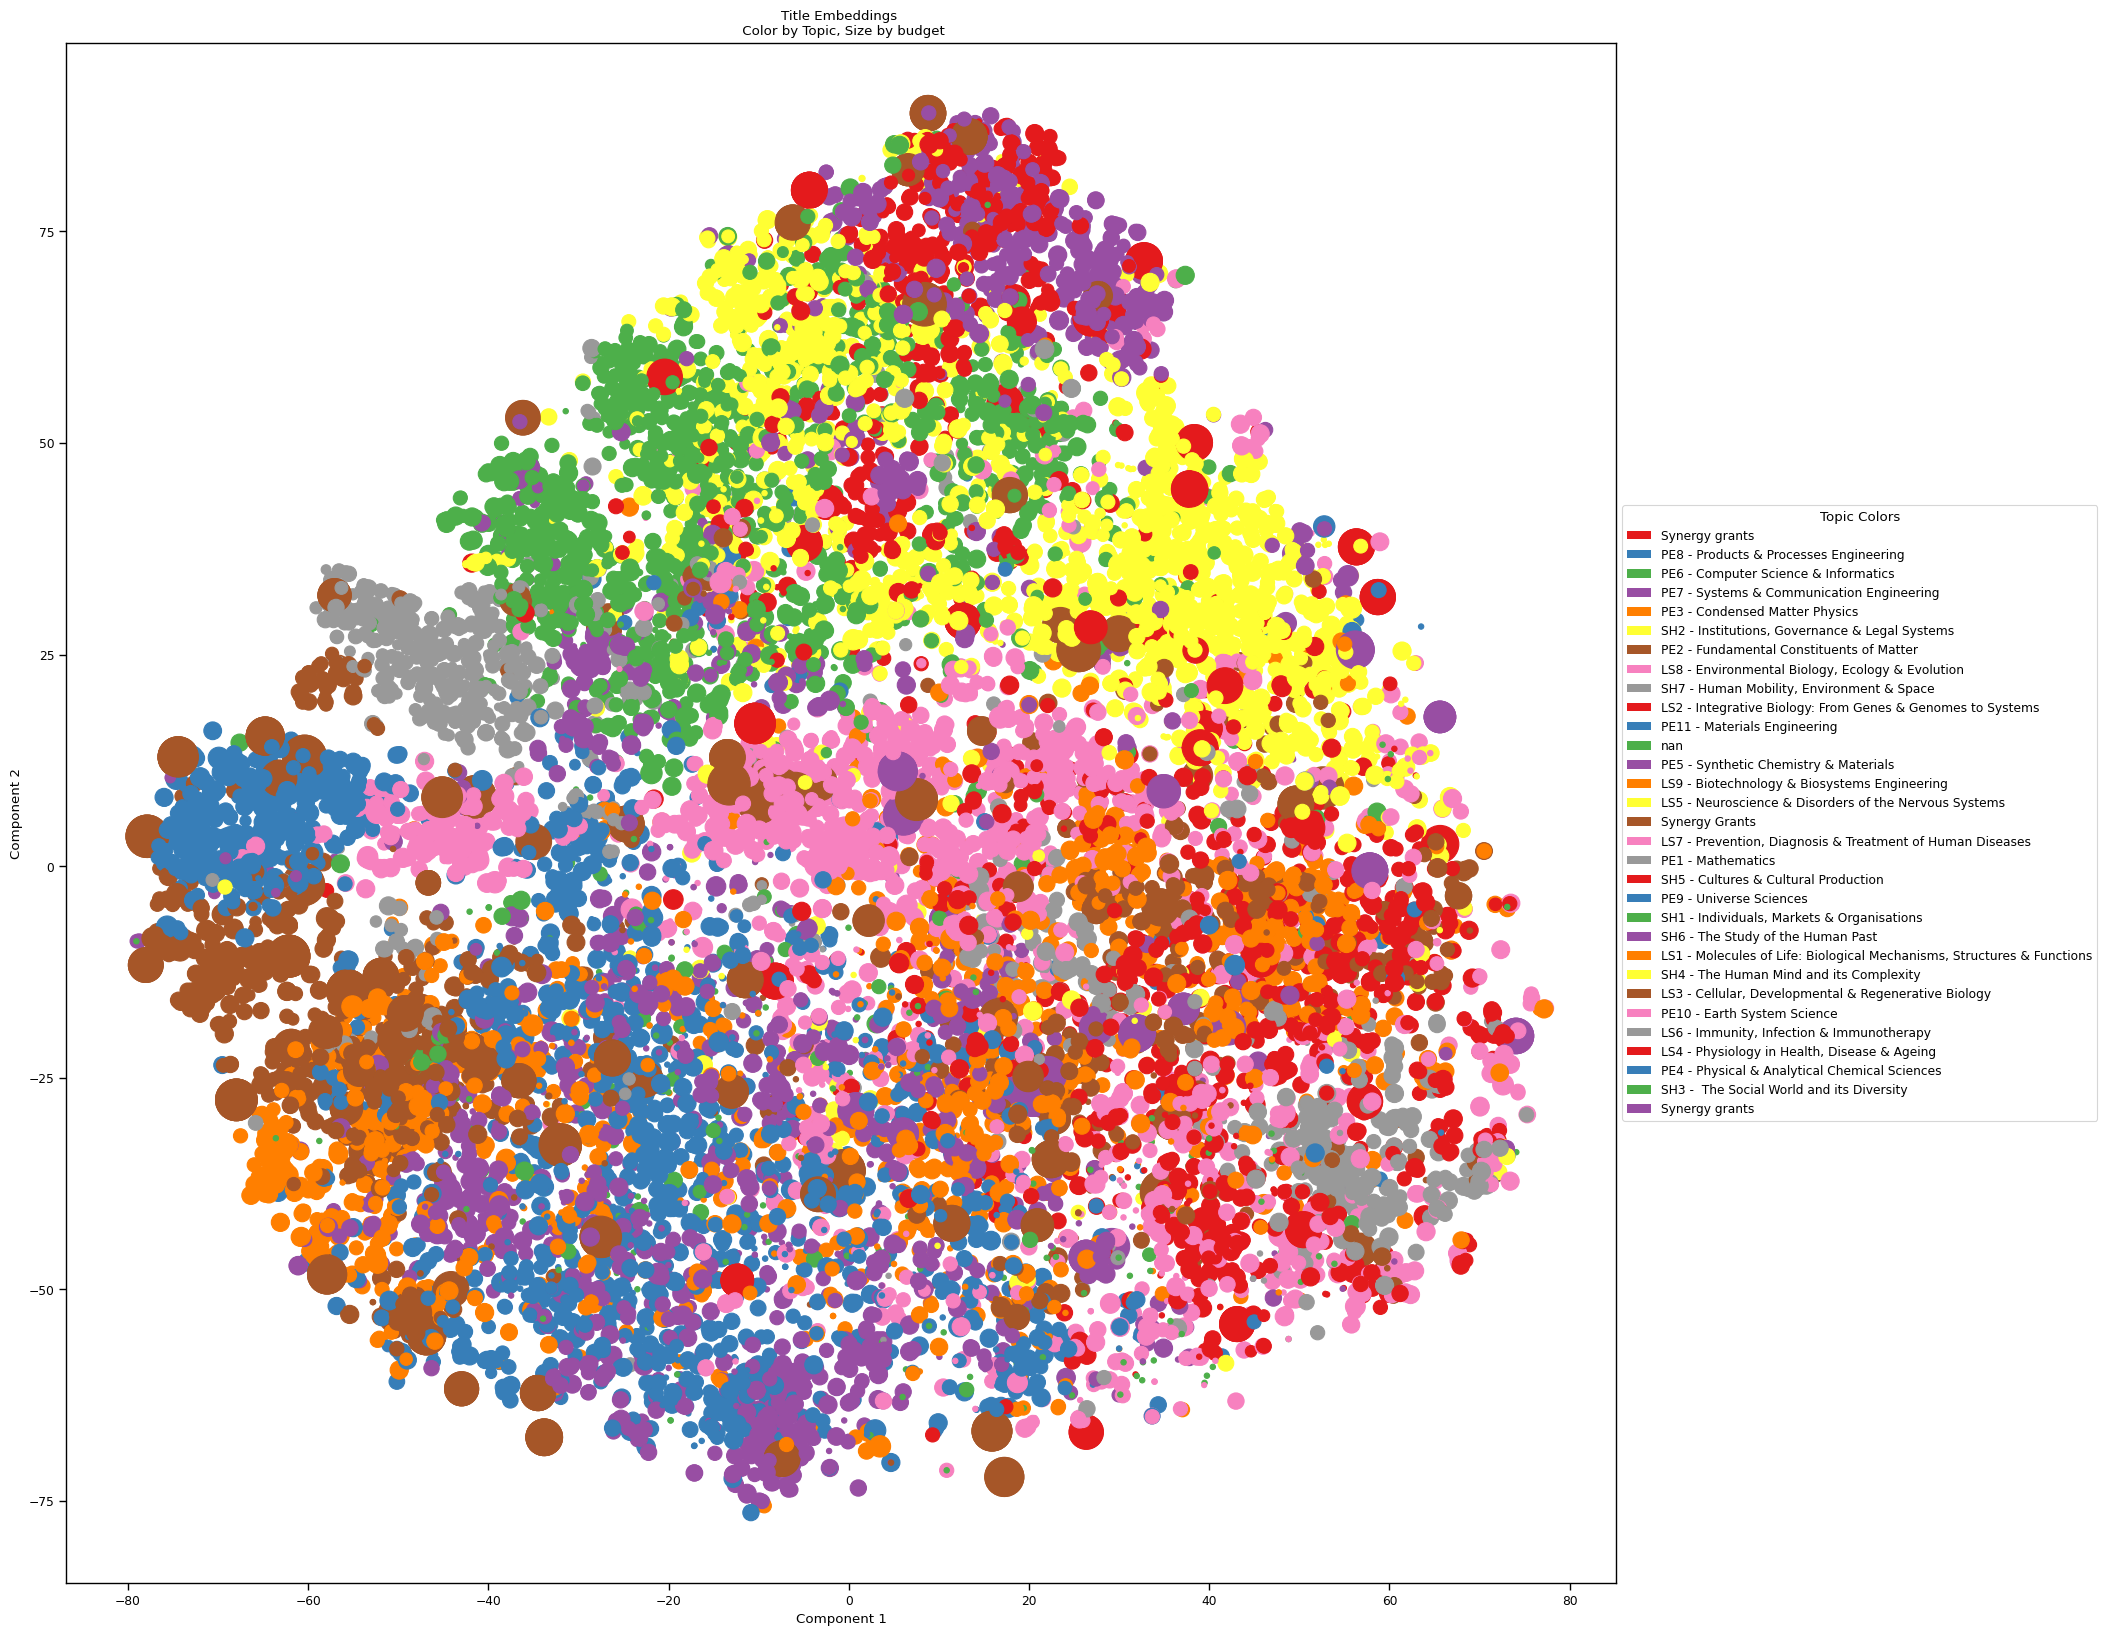

In [53]:
unique_topic = title_dataset.Topic.unique()
unique_topic_color_palette = sns.color_palette('Set1', n_colors=len(unique_topic))
topic_2_color = {topic:c for topic,c in list(zip(unique_topic, unique_topic_color_palette))}
colors_by_unique_topic = title_dataset.Topic.apply(lambda topic: topic_2_color[topic]).values


normalized_size = size_normalization(arr=title_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_title_result[:, 0], tsne_title_result[:, 1], s=normalized_size, color=colors_by_unique_topic)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Title Embeddings \n Color by Topic, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in topic_2_color.items()]
plt.legend(handles=legend_handles, title='Topic Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Let's visualize the title embeddings in relation to money (size) and university (color):

In [54]:
unique_university = title_dataset['Host Institution'].unique()
unique_university_color_palette = sns.color_palette('Set1', n_colors=len(unique_university))
university_2_color = {university:c for university,c in list(zip(unique_university, unique_university_color_palette))}
colors_by_unique_university = title_dataset['Host Institution'].apply(lambda university: university_2_color[university]).values


normalized_size = size_normalization(arr=title_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_title_result[:, 0], tsne_title_result[:, 1], s=normalized_size, color=colors_by_unique_university)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Title Embeddings \n Color by Host Institution, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in university_2_color.items()]
plt.legend(handles=legend_handles, title='Host Institution Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Let's visualize the title embeddings in relation to money (size) and country (color):

In [55]:
unique_Country_name = title_dataset["Country name"].unique()
unique_Country_name_color_palette = sns.color_palette('Set1', n_colors=len(unique_Country_name))
Country_name_2_color = {topic:c for topic,c in list(zip(unique_Country_name, unique_Country_name_color_palette))}
colors_by_unique_Country_name = title_dataset["Country name"].apply(lambda Country_name: Country_name_2_color[Country_name]).values


normalized_size = size_normalization(arr=title_dataset['Project budget'].values)
plt.figure(figsize=(20,20))
plt.scatter(tsne_title_result[:, 0], tsne_title_result[:, 1], s=normalized_size, color=colors_by_unique_Country_name)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Title Embeddings \n Color by Country, Size by budget')
legend_handles = [Patch(facecolor=color, label=item) for item, color in Country_name_2_color.items()]
plt.legend(handles=legend_handles, title='Country Colors', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## ***Predicting grant amount & what features importance***

Let's try and predict grant amount and see what features contibute the most to this prediction. We begin with processing data for ML models:

In [61]:
# Define columns to use
target_col = ["Project budget"]
categorical_cols = ["Grant type", "Topic", "Call ID", "Host Institution",
                    "City", "Country"]
numerical_cols = ["start_year", "days_duration"]
features_cols = categorical_cols + numerical_cols

# Create data frame of columns only
predicted_erc_full_df = erc_full_df[features_cols+target_col].copy()

# Make sure types are correct
dtype0= {
          "Grant type": "category",
          "Topic": "category",
          "Call ID": "category",
          "Host Institution": "category",
          "City": "category",
          "Country": "category",
    }

predicted_erc_full_df= predicted_erc_full_df.astype(dtype0)
print(f"\nerc_data_df dtypes:\n{predicted_erc_full_df.dtypes}\n")

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for c in categorical_cols:
  predicted_erc_full_df[f"{c}_encoded"] = label_encoder.fit_transform(
      predicted_erc_full_df[f'{c}'])

# Drop the original categorical columns
predicted_erc_full_df = predicted_erc_full_df.drop(columns=categorical_cols)

"""Option 2 - using dummies"""
# # Apply get_dummies to each categorical column
# dummy_col = pd.get_dummies(predicted_erc_full_df[categorical_cols])
# # Concat dummy_col with original data
# predicted_erc_full_df = pd.concat([predicted_erc_full_df, dummy_col], axis=1)
# # Drop the original categorical columns
# predicted_erc_full_df.drop(categorical_cols, axis=1, inplace=True)


erc_data_df dtypes:
Grant type          category
Topic               category
Call ID             category
Host Institution    category
City                category
Country             category
start_year             int64
days_duration          int64
Project budget       float32
dtype: object



'Option 2 - using dummies'

Next, let's split the data for training and testing:

In [62]:
# Split the data into train/test sets
relevant_df = predicted_erc_full_df

train_datasets_df, test_datasets_df = train_test_split(
    relevant_df, test_size=0.2,random_state=42)

print(f"train_datasets_df:  {train_datasets_df.shape}"
f" - {train_datasets_df.shape[0]/relevant_df.shape[0]*100}%")
print(f"test_datasets_df:   {test_datasets_df.shape}"
f" - {test_datasets_df.shape[0]/relevant_df.shape[0]*100}%")

X_train, y_train = train_datasets_df.drop(
    columns=target_col).to_numpy(), train_datasets_df[target_col].to_numpy()
X_test, y_test = test_datasets_df.drop(
    columns=target_col).to_numpy(), test_datasets_df[target_col].to_numpy()

y_test = y_test.squeeze()
y_test = y_test.squeeze()

print()
print(f'X_train.shape:  {X_train.shape}, y_train.shape:  {y_train.shape}')
print(f'X_test.shape:  {y_test.shape}, y_test.shape:  {X_test.shape}')

train_datasets_df:  (11500, 9) - 80.0%
test_datasets_df:   (2875, 9) - 20.0%

X_train.shape:  (11500, 8), y_train.shape:  (11500, 1)
X_test.shape:  (2875,), y_test.shape:  (2875, 8)


Next, let's train our model:

Best XGBoost Model Test MSE: 156763210000.0



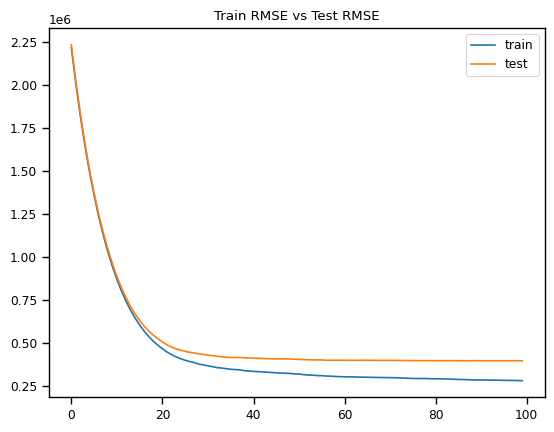

In [63]:
# Init XGBoost regression model
xgb_model = xgb.XGBRegressor()

# Define a parameter grid for Grid Search
param_grid = {
    "max_depth": [3,5,7],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "min_child_weight": [1, 3, 5],
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5,
                           scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and retrain the model with them
best_params = grid_search.best_params_
xgb_model = xgb.XGBRegressor(**best_params)

eval_set = [(X_train, y_train), (X_test,y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


# Evaluate the XGBoost model on the test set
y_pred = xgb_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print("Best XGBoost Model Test MSE:", mse_test)
print()

# retrieve performance metrics
results = xgb_model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.title('Train RMSE vs Test RMSE')
plt.legend()
plt.show()

Next, let's evaulte our model on the test set:

In [64]:
def bootstrap(data, criteria_true_col, criteria_pred_col, criteria,
              num_bootstrap_samples):
    n = len(criteria_true_col)
    criteria_values = []
    for _ in range(num_bootstrap_samples):
        # Generate bootstrap sample (indices)
        indices = np.random.choice(len(criteria_true_col), size=n,
                                   replace=True)
        # curr_data = X_test[indices]
        y_bootstrap_sample = criteria_true_col[indices]
        y_pred_bootstrap = criteria_pred_col[indices]

        # Compute information criteria for the bootstrap sample
        criteria_value = criteria(y_bootstrap_sample, y_pred_bootstrap,
                                  squared=False)
        criteria_values.append(criteria_value)
    return criteria_values

def calc_lower_bound_upper_bound_ci(criteria_values, confidence_level):
  # Calculate confidence interval based on
  lower_percentile = (1 - confidence_level) / 2
  upper_percentile = 1 - lower_percentile
  lower_bound = np.percentile(criteria_values, lower_percentile * 100)
  upper_bound = np.percentile(criteria_values, upper_percentile * 100)

  return lower_bound.item(), upper_bound.item()

In [65]:
num_bootstrap_samples = 100
confidence_level = 0.95
information_criteria_name = "RMSE"
y_pred_test = xgb_model.predict(X_test)
criteria = mean_squared_error
relevant_overall_criteria = criteria(y_test, y_pred_test, squared=False)

criteria_values = bootstrap(data=X_test,criteria_true_col=y_test,
                            criteria_pred_col=y_pred_test, criteria=criteria,
                            num_bootstrap_samples=num_bootstrap_samples)
lower_bound, upper_bound = calc_lower_bound_upper_bound_ci(
    criteria_values=criteria_values, confidence_level=confidence_level)
standard_error = np.std(criteria_values, axis=0)
print("The {}% confidence interval of {} is [{}, {}] \n standard_error: {}".format(
    confidence_level * 100,information_criteria_name, lower_bound,
    upper_bound, standard_error))

The 95.0% confidence interval of RMSE is [344858.33984375, 439079.73124999995] 
 standard_error: 25899.634765625


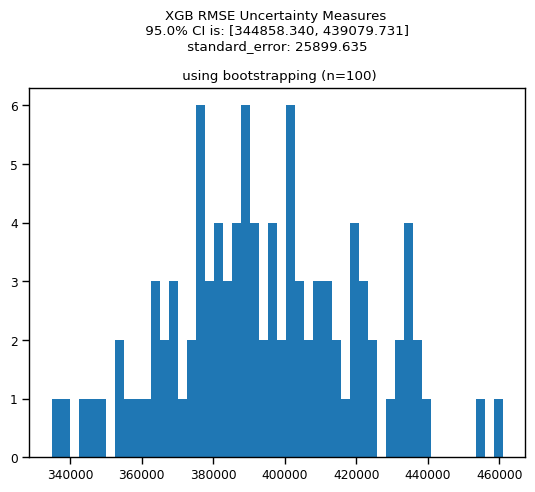

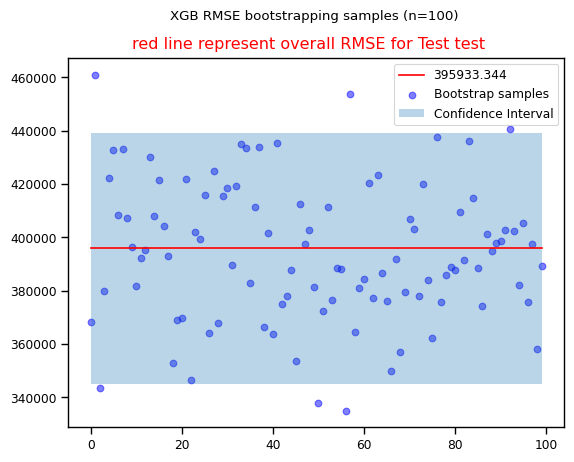

In [66]:
# hist plot
plt.hist(criteria_values, bins=50)
plt.title(f"XGB {information_criteria_name} Uncertainty Measures \n "
          f"{confidence_level*100}% CI is: [{lower_bound:0.3f}, "
          f"{upper_bound:.3f}] \n standard_error: {standard_error:.3f} "
          f"\n\n using bootstrapping (n={num_bootstrap_samples})")
plt.show()

print()

# samples plot
x_plot = np.arange(len(criteria_values))
y_plot = [relevant_overall_criteria] * len(x_plot)
plt.plot(x_plot, y_plot, label=f'{relevant_overall_criteria:.3f}', color="red")
plt.scatter(x_plot, criteria_values, label="Bootstrap samples", color="blue",
            alpha=0.5)
plt.fill_between(x_plot, lower_bound, upper_bound, alpha=0.3,
                 label="Confidence Interval")
plt.title(f"XGB {information_criteria_name} bootstrapping samples"
          f" (n={num_bootstrap_samples}) \n\n")
plt.figtext(0.50, 0.90, (f"red line represent overall "
                         f"{information_criteria_name} for Test test"),
            fontsize="large", color="r", ha ="center")
leg = plt.legend(loc='best')
plt.show()

Next, let's take a look at the feture importance:

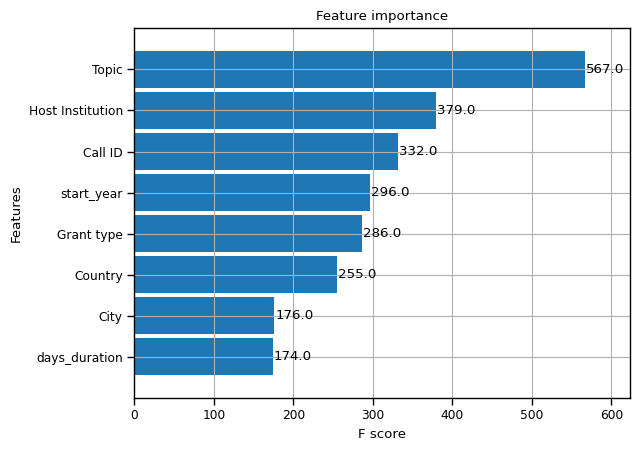

In [67]:
xgb_model.get_booster().feature_names = features_cols
plot_importance(xgb_model, height=0.9)
plt.show()

Lastly, let's take a look at the feature importance using SHAP:

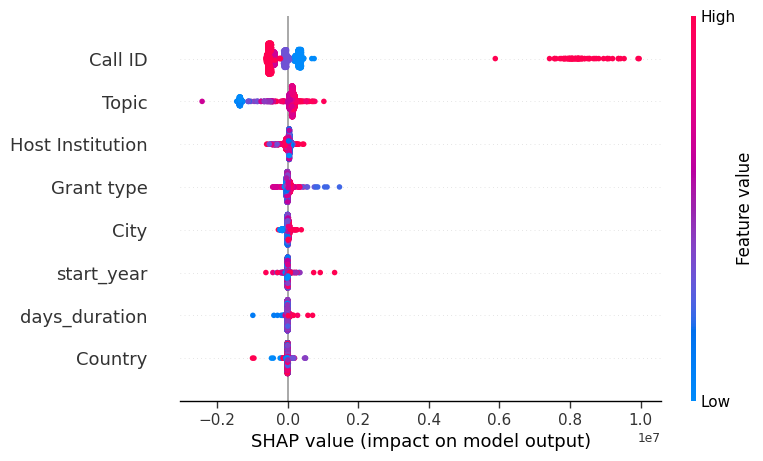

In [68]:
# SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features_cols)

## ***Integration of university rating in the analysis***

Let's get university rating data from kaggle:

In [69]:
# Config kaggle
!mkdir /root/.kaggle/
api_token = {"username":"leorrose","key":"cb0dd45990ab2c8d83a457883cca0f2d"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
# Download data
!kaggle datasets download -d r1chardson/the-world-university-rankings-2011-2023
# Unzip data
!unzip -o the-world-university-rankings-2011-2023.zip

 79% 1.00M/1.27M [00:00<00:00, 1.09MB/s]
100% 1.27M/1.27M [00:01<00:00, 1.31MB/s]
Archive:  the-world-university-rankings-2011-2023.zip
  inflating: 2011_rankings.csv       
  inflating: 2012_rankings.csv       
  inflating: 2013_rankings.csv       
  inflating: 2014_rankings.csv       
  inflating: 2015_rankings.csv       
  inflating: 2016_rankings.csv       
  inflating: 2017_rankings.csv       
  inflating: 2018_rankings.csv       
  inflating: 2019_rankings.csv       
  inflating: 2020_rankings.csv       
  inflating: 2021_rankings.csv       
  inflating: 2022_rankings.csv       
  inflating: 2023_rankings.csv       


Let's visualize the corraltion between university rank and budget per year:

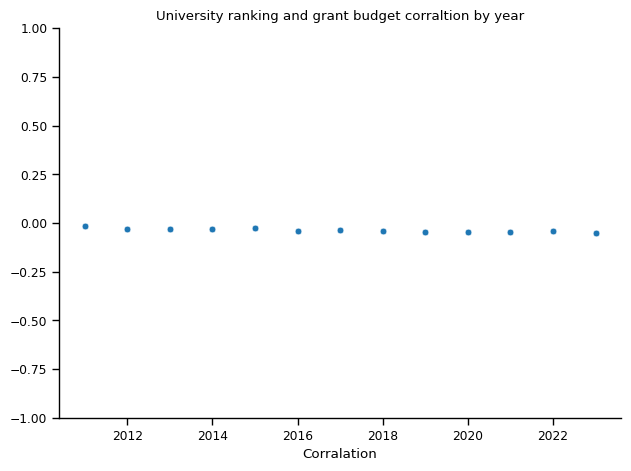

In [70]:
def rank_to_int(rank: str):
  """Convert a rank string to an integer representation.

    Parameters:
        rank (str): The rank string to be converted to an integer.

    Returns:
        int: The numerical rank extracted from the rank string. Returns -1 if conversion fails.
    """
  rank = re.split(r'[-—–]', str(rank).replace("=","").replace("+",""))[0]
  try:
    return int(rank)
  except:
    return -1

years = []
corrs = []

for year in range(2011, 2024):
  university_rankings = pd.read_csv(f"{year}_rankings.csv")
  uni_2_rank = dict(zip(university_rankings['name'].str.lower(), university_rankings['rank'].apply(rank_to_int).astype(int)))
  uni_2_rank = {key: value for key, value in uni_2_rank.items() if value != -1}
  erc_loop = erc_full_df[erc_full_df["Host Institution"].str.lower().isin(uni_2_rank.keys())]
  erc_loop["rank"] = erc_loop["Host Institution"].str.lower().apply(uni_2_rank.get)
  years.append(year)
  corrs.append(erc_loop['Project budget'].corr(erc_loop['rank']))

sns.scatterplot(x=years, y=corrs, )
plt.title(f"University ranking and grant budget corraltion by year")
plt.xlabel("Year")
plt.xlabel("Corralation")
plt.ylim(-1, 1)
sns.despine()
plt.tight_layout()
plt.show()

## ***Integration of country currency in the analysis***

Let's visualize the corraltion between currency and budget:

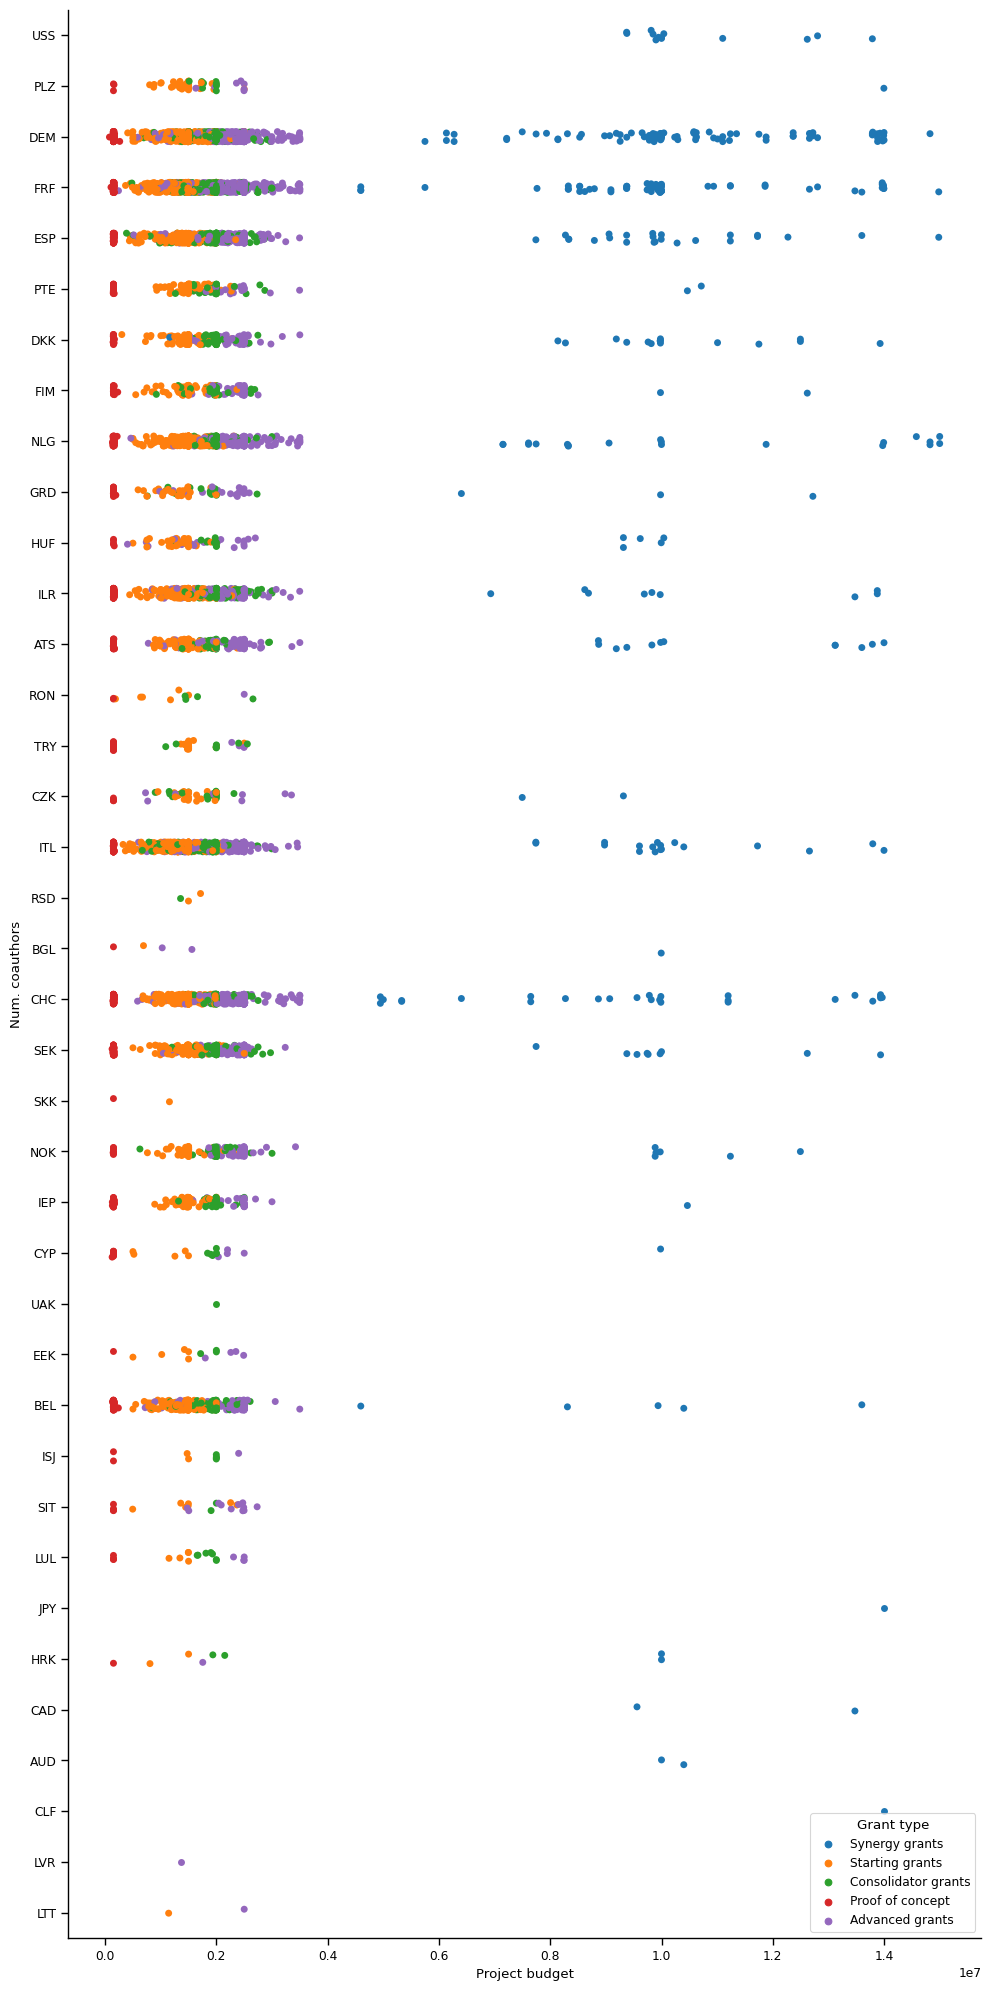

In [71]:
currency_df = pd.read_csv("https://raw.githubusercontent.com/datasets/currency-codes/master/data/codes-all.csv")
country_2_currency = dict(zip(currency_df['Entity'].str.lower(), currency_df['AlphabeticCode']))
erc_full_df["currency"] = erc_full_df["Country name"].apply(lambda x: country_2_currency.get(x.lower()))
erc_full_df = erc_full_df[~erc_full_df["currency"].isna()]

fig, ax = plt.subplots(figsize=(10, 20))
sns.stripplot(x='Project budget', y='currency', data=erc_full_df, hue='Grant type', ax=ax)
plt.xlabel('Project budget')
plt.ylabel('Num. coauthors')
sns.despine()
plt.tight_layout()
plt.show()

## ***Integration of google scholar in the analysis***

Let's read the google scholar data that we scraped (code: [scholar_scrapper.ipynb](https://github.com/leorrose/ERC_analysis/blob/main/scholar_scrapper.ipynb))

In [72]:
cites_per_year = pd.read_csv("https://raw.githubusercontent.com/leorrose/ERC_analysis/main/data/cites_per_year.csv")
coauthors = pd.read_csv("https://raw.githubusercontent.com/leorrose/ERC_analysis/main/data/coauthors.csv")
publications_per_year = pd.read_csv("https://raw.githubusercontent.com/leorrose/ERC_analysis/main/data/publications_per_year.csv")

Let's see the correlation between grant budget (before getting grant) and PI number of publications:

{'Advanced grants': -0.08497962330043723, 'Consolidator grants': -0.23772060753783003, 'Proof of concept': 0.4064271355772909, 'Starting grants': -0.11376426252817852, 'Synergy grants': -0.47964758940138114}


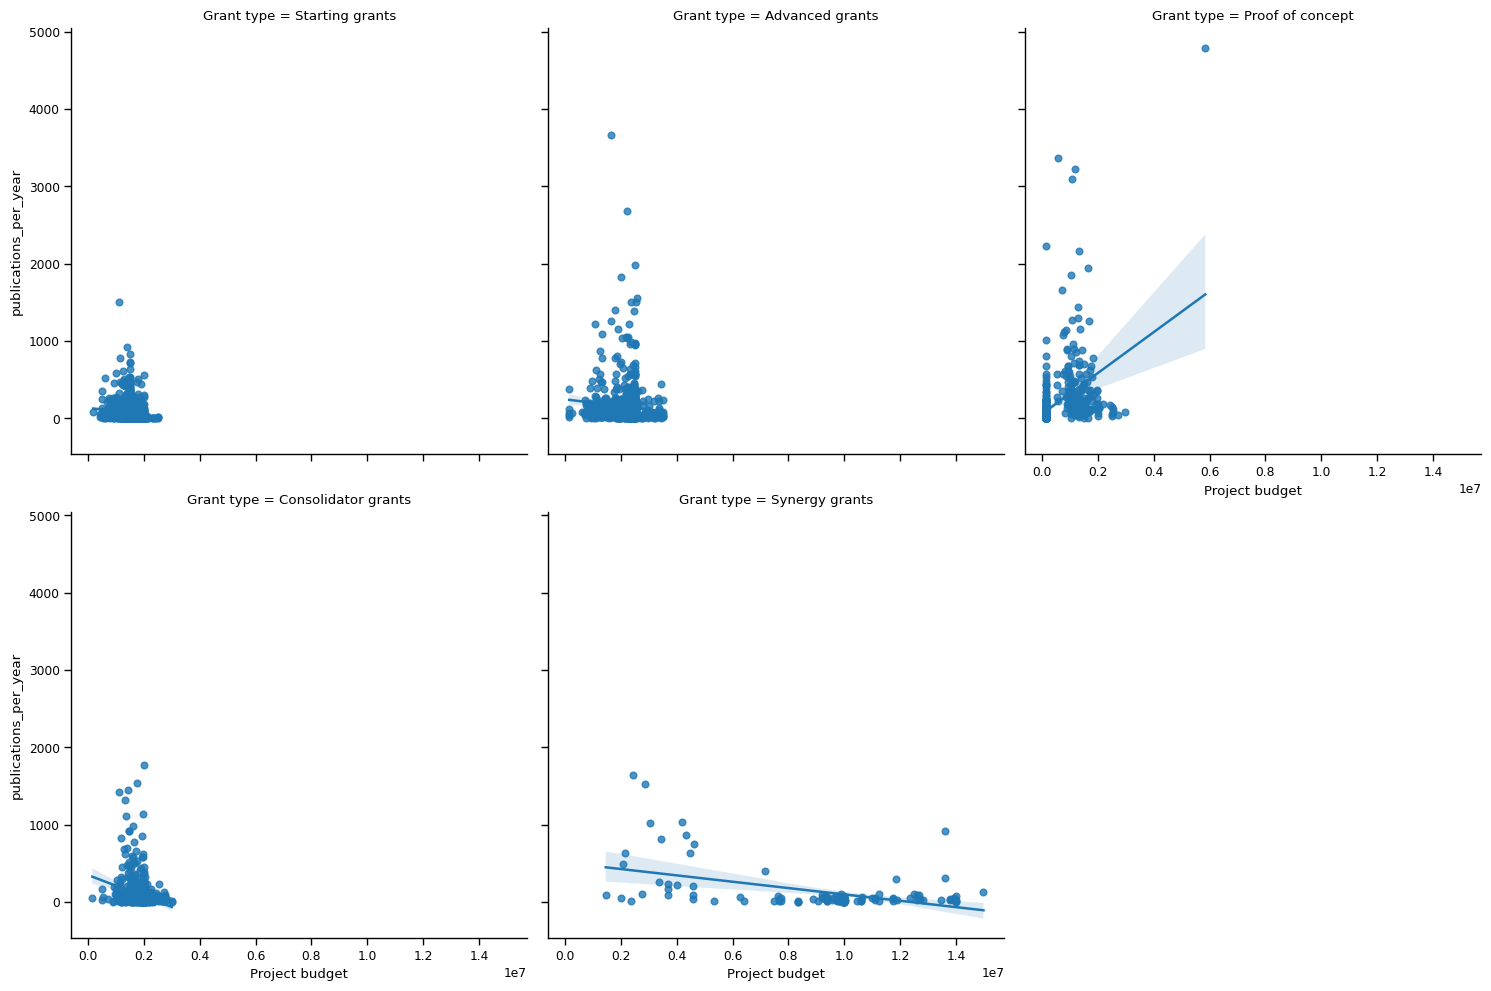

In [73]:
merged_df = pd.merge(erc_full_df, publications_per_year, left_on='PI', right_on='author', how='inner')
publications_by_budget = merged_df[merged_df.start_year < merged_df.year].groupby("PI").agg({"Project budget": "mean", "publications_per_year": "sum"})
grant_type = merged_df[merged_df.start_year > merged_df.year].groupby("PI")["Grant type"].agg(lambda x: x.value_counts().idxmax())
publications_by_budget["Grant type"] = grant_type
publications_by_budget_by_grant_type = publications_by_budget.groupby("Grant type")
correlations = {}
for group, data in publications_by_budget_by_grant_type:
    correlation = data['Project budget'].corr(data['publications_per_year'])
    correlations[group] = correlation
print(correlations)
sns.lmplot(x='Project budget', y='publications_per_year', data=publications_by_budget, col='Grant type', col_wrap=3)
plt.xlabel('Project budget')
plt.ylabel('Publications per Year')
plt.show()

Let's see the correlation between grant budget (after getting grant) and PI number of publications:

{'Advanced grants': 0.036925247590102614, 'Consolidator grants': -0.21287158360937333, 'Proof of concept': 0.3433664455164197, 'Starting grants': -0.04247052512917627, 'Synergy grants': 0.23142129343864296}


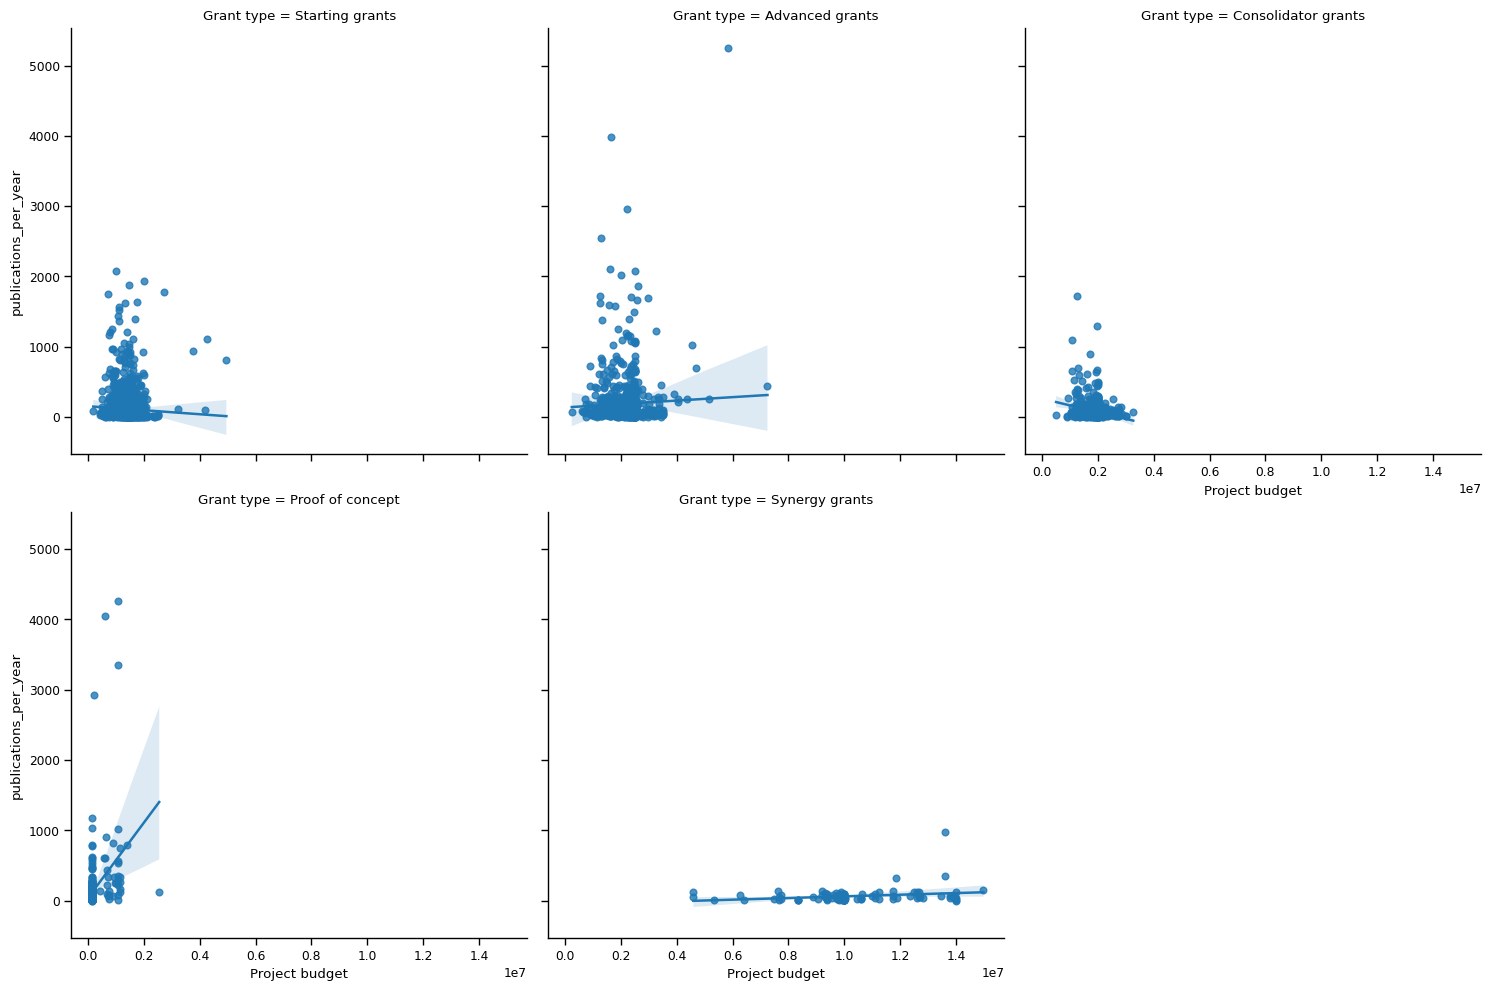

In [74]:
merged_df = pd.merge(erc_full_df, publications_per_year, left_on='PI', right_on='author', how='inner')
publications_by_budget = merged_df[merged_df.start_year <= merged_df.year].groupby("PI").agg({"Project budget": "mean", "publications_per_year": "sum"})
grant_type = merged_df[merged_df.start_year < merged_df.year].groupby("PI")["Grant type"].agg(lambda x: x.value_counts().idxmax())
publications_by_budget["Grant type"] = grant_type
publications_by_budget_by_grant_type = publications_by_budget.groupby("Grant type")
correlations = {}
for group, data in publications_by_budget_by_grant_type:
    correlation = data['Project budget'].corr(data['publications_per_year'])
    correlations[group] = correlation
print(correlations)
sns.lmplot(x='Project budget', y='publications_per_year', data=publications_by_budget, col='Grant type', col_wrap=3)
plt.xlabel('Project budget')
plt.ylabel('Publications per Year')
plt.show()

Let's see the correlation between grant budget (before getting grant) and PI number of citations:

{'Advanced grants': -0.06823158645799046, 'Consolidator grants': -0.18680633049142342, 'Proof of concept': 0.2896337953651837, 'Starting grants': -0.10016401098959685, 'Synergy grants': -0.4418322872123086}


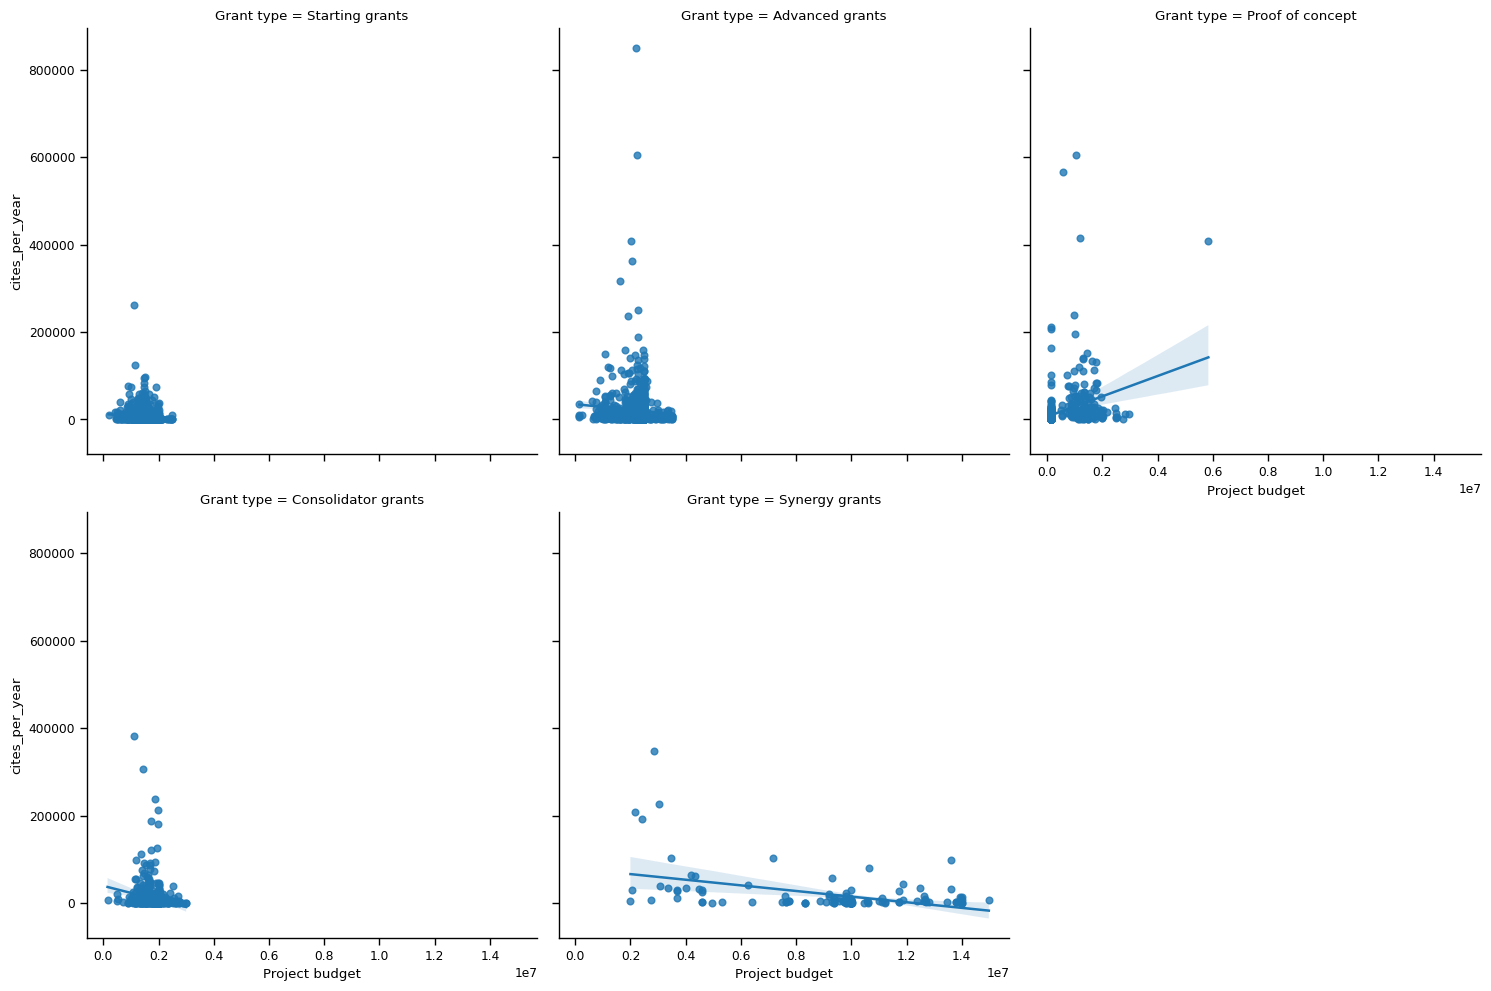

In [75]:
merged_df = pd.merge(erc_full_df, cites_per_year, left_on='PI', right_on='author', how='inner')
citations_by_budget = merged_df[merged_df.start_year < merged_df.year].groupby("PI").agg({"Project budget": "mean", "cites_per_year": "sum"})
grant_type = merged_df[merged_df.start_year > merged_df.year].groupby("PI")["Grant type"].agg(lambda x: x.value_counts().idxmax())
citations_by_budget["Grant type"] = grant_type
citations_by_budget_by_grant_type = citations_by_budget.groupby("Grant type")
correlations = {}
for group, data in citations_by_budget_by_grant_type:
    correlation = data['Project budget'].corr(data['cites_per_year'])
    correlations[group] = correlation
print(correlations)
sns.lmplot(x='Project budget', y='cites_per_year', data=citations_by_budget, col='Grant type', col_wrap=3)
plt.xlabel('Project budget')
plt.ylabel('Citations per Year')
plt.show()

Let's see the correlation between grant budget (after getting grant) and PI number of citations:

{'Advanced grants': -0.07862772078293491, 'Consolidator grants': -0.19512603845299428, 'Proof of concept': 0.3134956167962401, 'Starting grants': -0.10575635727756466, 'Synergy grants': -0.4321952861001016}


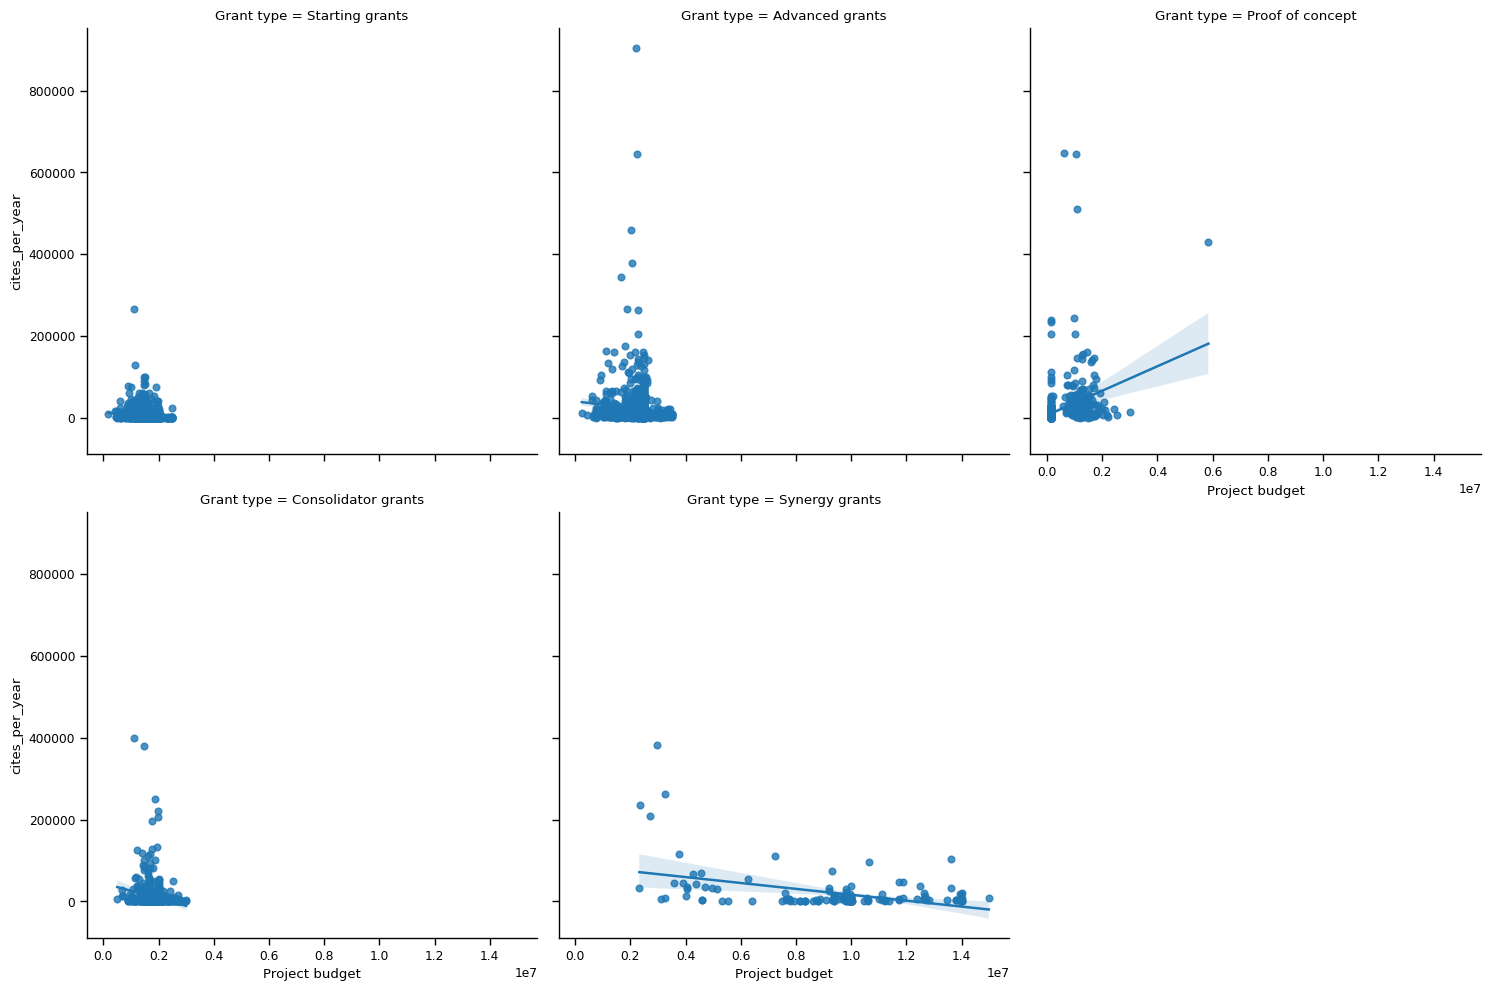

In [76]:
merged_df = pd.merge(erc_full_df, cites_per_year, left_on='PI', right_on='author', how='inner')
citations_by_budget = merged_df[merged_df.start_year <= merged_df.year].groupby("PI").agg({"Project budget": "mean", "cites_per_year": "sum"})
grant_type = merged_df[merged_df.start_year > merged_df.year].groupby("PI")["Grant type"].agg(lambda x: x.value_counts().idxmax())
citations_by_budget["Grant type"] = grant_type
citations_by_budget_by_grant_type = citations_by_budget.groupby("Grant type")
correlations = {}
for group, data in citations_by_budget_by_grant_type:
    correlation = data['Project budget'].corr(data['cites_per_year'])
    correlations[group] = correlation
print(correlations)
sns.lmplot(x='Project budget', y='cites_per_year', data=citations_by_budget, col='Grant type', col_wrap=3)
plt.xlabel('Project budget')
plt.ylabel('Citations per Year')
plt.show()

Let's see the correlation between grant budget and PI number of coauthors:

{'Advanced grants': 0.048520849049055535, 'Consolidator grants': 0.13225428237744905, 'Proof of concept': -0.06296692141021065, 'Starting grants': 0.03915319984784937, 'Synergy grants': 0.0387638662188935}


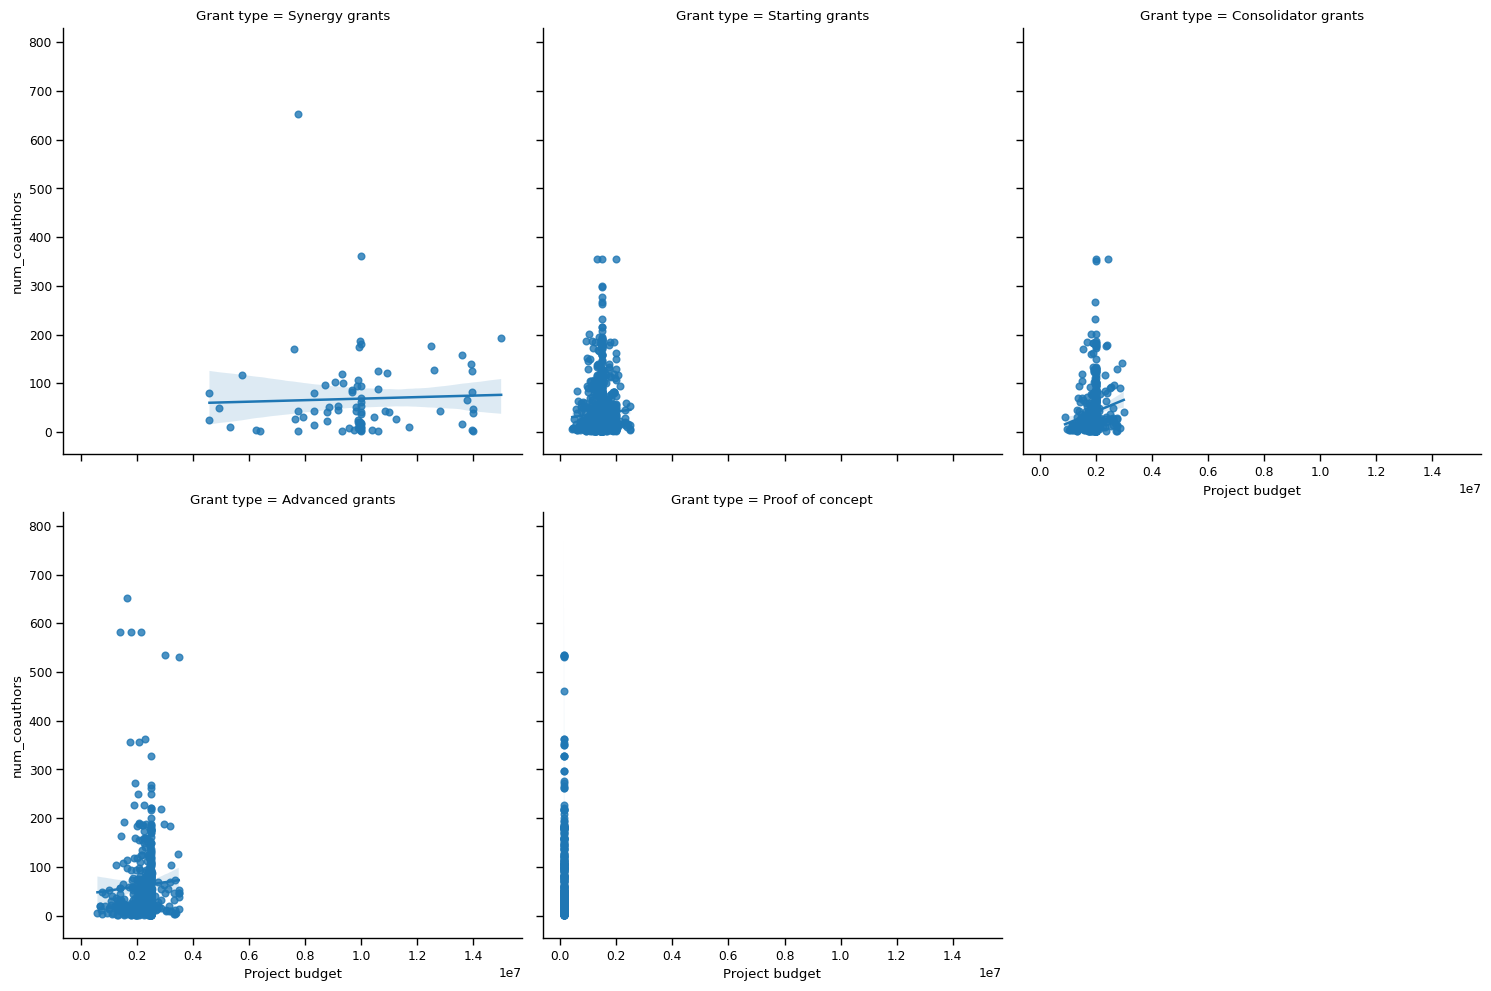

In [77]:
merged_df = pd.merge(erc_full_df, coauthors.groupby("author_name").size().to_frame().rename(columns={0: "num_coauthors"}), left_on='PI', right_on='author_name', how='inner')
coauthors_by_grant_type = merged_df.groupby("Grant type")
correlations = {}
for group, data in coauthors_by_grant_type:
    correlation = data['Project budget'].corr(data['num_coauthors'])
    correlations[group] = correlation
print(correlations)
sns.lmplot(x='Project budget', y='num_coauthors', data=merged_df, col='Grant type', col_wrap=3)
plt.xlabel('Project budget')
plt.ylabel('Num. coauthors')
plt.show()